# Chunking and SQLite

In this notebook, we'll see a couple of techniques that can be used when working with large file in Python.

In [75]:
import pandas as pd
import numpy as np
import sqlite3
from tqdm.notebook import tqdm

In [ ]:
db = sqlite3.connect('nppes.sqlite')

Before we do anything else, let's see how many rows are contained in the Calls for Service file. 

In [ ]:
#using terminal  "wc -l file.txt"

In [ ]:
npi_cols=['NPI',
 'Entity Type Code',
 'Replacement NPI',
 'Employer Identification Number (EIN)',
 'Provider Organization Name (Legal Business Name)',
 'Provider Last Name (Legal Name)',
 'Provider First Name',
 'Provider Credential Text',
 'Provider First Line Business Practice Location Address',
 'Provider Second Line Business Practice Location Address',
 'Provider Business Practice Location Address City Name',
 'Provider Business Practice Location Address State Name',
 'Provider Business Practice Location Address Postal Code',
 'Provider Gender Code',
 'Healthcare Provider Taxonomy Code_1',
 'Healthcare Provider Primary Taxonomy Switch_1',
 'Healthcare Provider Taxonomy Code_2',
 'Healthcare Provider Primary Taxonomy Switch_2',
 'Healthcare Provider Taxonomy Code_3',
 'Healthcare Provider Primary Taxonomy Switch_3',
 'Healthcare Provider Taxonomy Code_4',
 'Healthcare Provider Primary Taxonomy Switch_4',
 'Healthcare Provider Taxonomy Code_5',
 'Healthcare Provider Primary Taxonomy Switch_5',
 'Healthcare Provider Taxonomy Code_6',
 'Healthcare Provider Primary Taxonomy Switch_6',
 'Healthcare Provider Taxonomy Code_7',
 'Healthcare Provider Primary Taxonomy Switch_7',
 'Healthcare Provider Taxonomy Code_8',
 'Healthcare Provider Primary Taxonomy Switch_8',
 'Healthcare Provider Taxonomy Code_9',
 'Healthcare Provider Primary Taxonomy Switch_9',
 'Healthcare Provider Taxonomy Code_10',
 'Healthcare Provider Primary Taxonomy Switch_10',
 'Healthcare Provider Taxonomy Code_11',
 'Healthcare Provider Primary Taxonomy Switch_11',
 'Healthcare Provider Taxonomy Code_12',
 'Healthcare Provider Primary Taxonomy Switch_12',
 'Healthcare Provider Taxonomy Code_13',
 'Healthcare Provider Primary Taxonomy Switch_13',
 'Healthcare Provider Taxonomy Code_14',
 'Healthcare Provider Primary Taxonomy Switch_14',
 'Healthcare Provider Taxonomy Code_15',
 'Healthcare Provider Primary Taxonomy Switch_15']

First, we need to connect to our database. The connect function will either create a new database if one does not already exist or connect to an existing one.

Now, we can chunk through the data and for each row, add the rows to a table in our sqlite database. 
To keep track of how much progress has been made, we can use the `tqdm` library.

In [ ]:
#create a function to loop through taxonomy of providers code
def find_primary_code(row):
    for i in range(1,16):
        if row[f'healthcare_provider_primary_taxonomy_switch_{i}']=='Y':
            return row[f'healthcare_provider_taxonomy_code_{i}']
#chunking in
for chunk in tqdm(pd.read_csv('NPPES_Data_Dissemination_February_2021/npidata_pfile_20050523-20210207.csv', usecols=npi_cols, chunksize = 10000)):
    chunk.columns = [x.lower().replace(' ', '_').replace('(', '').replace(')','').replace('*','') for x in chunk.columns]      # Clean up the column names
    chunk['taxonomy']= chunk.apply(lambda row: find_primary_code(row), axis=1)  #use the function above to create taxonomy column
    chunk=chunk[chunk.columns.drop(list(chunk.filter(regex='healthcare_provider_')))] #drop providers taxonomy code colums not needed anymore
    chunk.to_sql('npi_data', db, if_exists = 'append', index = False)


In [76]:
db.close()

In [ ]:
#pull the npi_data back to pandas and make data frame

db = sqlite3.connect('nppes.sqlite')
query='''
select *
from npi_data
order by npi;
'''
npi_data = pd.read_sql(query, db)
npi_data

In [ ]:
db.close()

In [ ]:
npi_data.duplicated(subset=['npi']).value_counts() #check for duplicates in npi incase chunking and appending created duplicate

In [ ]:
npi_data=npi_data.drop_duplicates(subset=['npi'])

In [ ]:
#add the nucc_taxtable to nppes database 
db = sqlite3.connect('nppes.sqlite')
nucc_tax=pd.read_csv('NPPES_Data_Dissemination_February_2021/nucc_taxonomy_210.csv')
nucc_tax.columns = [x.lower().replace(' ', '_') for x in nucc_tax.columns]
nucc_tax.to_sql('nucc_tax', db,  if_exists='append', index = False)    


In [ ]:
#pull the nucc_tax back to pandas and make data frame
query='''
select *
from nucc_tax;
'''
nucc_tax = pd.read_sql(query, db)
nucc_tax

In [ ]:
db.close()

In [ ]:
nucc_tax.info()

To speed up queries which use a specific column, we can create an **index** on that column. This causes the database to store that column in a way that helps it to retrieve rows quicker.

In [ ]:
#db = sqlite3.connect('nppes.sqlite')
#db.execute('CREATE INDEX taxonomy ON npi_data(taxonomy)')
#db.execute('CREATE INDEX code ON nucc_tax(code)')

In [ ]:
#add the cbsa table to nppes database 

db = sqlite3.connect('nppes.sqlite')
cbsa=pd.read_csv('NPPES_Data_Dissemination_February_2021/ZIP_CBSA_122020.csv')
cbsa.columns = [x.lower().replace(' ', '_') for x in cbsa.columns]
cbsa.to_sql('cbsa', db,  if_exists='append', index = False)

In [ ]:
#pull the cbsa back to pandas and make data frame
db = sqlite3.connect('nppes.sqlite')
query= '''
select *       
from cbsa 
'''
cbsa = pd.read_sql(query, db)
cbsa

In [ ]:
#db = sqlite3.connect('nppes.sqlite')
#query= '''
#select *      
#from npi_data as np
#left join nucc_tax as nu
#on np.taxonomy=nu.code 
#join cbsa as c
#on np.provider_business_practice_location_address_postal_code=c.zip '''
#npp_nucc_tax = pd.read_sql(query, db)
#npp_nucc_tax

In [ ]:
cbsa.info()

In [ ]:
#left merge npi_data frame to nucc_tax (lefet merge to preserve all data on npi_data) These cal also be achived by hashed sqlite code abo

npp_nucc=pd.merge(npi_data, nucc_tax,left_on='taxonomy', right_on='code', how='left')

In [ ]:
df.duplicated(subset=['npi'], ).value_counts()

In [ ]:
npp_nucc.duplicated(subset=['npi']).value_counts()

In [ ]:
npp_nucc.head(50)


In [ ]:
#the postal_code and zip have diffrent length digits and data type. convert to string and get the first five digits

npp_nucc['postal_code']=npp_nucc['provider_business_practice_location_address_postal_code'].astype(str).str[0:5]

cbsa['zip1']=cbsa['zip'].astype(str).str[0:5]


In [ ]:
#merge cbsa data frame to npi_data + nucc_tax data from previous merge
npp_nucc_cbsa=pd.merge(npp_nucc, cbsa,left_on= 'postal_code', right_on='zip1', how='left')

In [ ]:
npp_nucc_cbsa.duplicated(subset=['npi']).value_counts()

In [ ]:
#drop duplicates due to zip matching multiple cbsa based on tot_ratio column
npp_nucc_cbsa=npp_nucc_cbsa.sort_values(by=['npi','tot_ratio']).drop_duplicates('npi', keep='last')

In [ ]:
#subset only to nashville area cbsa
npp_nucc_cbsa_nash=npp_nucc_cbsa[npp_nucc_cbsa['cbsa']==34980]


In [ ]:
#save the nashville area cbsa filse to csv (it has 38414 rows × 36 columns)
npp_nucc_cbsa_nash.to_csv('npp_taxo_cbsa_nash.csv',index=False)

In [ ]:
npp_nucc_cbsa[['npi','specialization','zip']].head(50)

In [2]:
#add hop table to nppes database while also subseting on transaction and avarage wait days

db = sqlite3.connect('nppes.sqlite')
for chunk in tqdm(pd.read_csv('DocGraph_Hop_Teaming_2017_Non_Commercial/DocGraph_Hop_Teaming_2017.csv', chunksize = 100000)):
    chunk=chunk[(chunk['transaction_count']>=50) & (chunk['average_day_wait']<=50)]
    chunk.to_sql('hop', db, if_exists ='append', index = False)


In [ ]:
#pull the hop table using pandas to data frame

db = sqlite3.connect('nppes.sqlite')
query='''
select *
from hop;
'''
hop_team = pd.read_sql(query, db)
hop_team 

In [3]:
db.close()

# Here I was thinking about edge wise column, so I concatnated (vertical) the two merges above. something to explore later. I shift to horizontal merging.

In [ ]:
npp_nucc_cbsa_nash=pd.read_csv('npp_taxo_cbsa_nash.csv') 


In [ ]:

#This is memory expensive method. so, I am hashing it
#npp_nucc_cbsa_nash_hop=pd.merge(npp_nucc_cbsa_nash, hop_team, left_on= 'npi', right_on='from_npi', how='inner')

In [ ]:
#npp_nucc_cbsa_nash_hop.columns.tolist()

In [ ]:
#npp_nucc_cbsa_nash_hop_from=npp_nucc_cbsa_nash_hop.drop(
    #columns=[
        'replacement_npi',
        'employer_identification_number_ein',
        'provider_name_prefix_text',
        'provider_name_suffix_text',
        'provider_first_line_business_practice_location_address',
        'provider_second_line_business_practice_location_address',
        'provider_business_practice_location_address_state_name',
        'provider_gender_code',
        'taxonomy',
        'code',
        'effective_date',
        'deactivation_date',
        'last_modified_date',
        'notes',
        'display_name',
        'zip',
        'cbsa',
        'res_ratio',
        'bus_ratio',
        'oth_ratio',
        'tot_ratio',
        'zip1'])

In [ ]:
#npp_nucc_cbsa_nash_hop_from_to=pd.merge(npp_nucc_cbsa_nash_hop_from, hop_team, left_on= 'npi', right_on='to_npi', how='inner')

In [ ]:
#npp_nucc_cbsa_nash_hop_horiz=pd.merge(npp_nucc_cbsa_nash_hop, hop_team, left_on= 'npi', right_on='to_npi', how='inner')

In [ ]:
#npp_nucc_cbsa_nash_hop_from_to.info()

In [ ]:
#npp_nucc_cbsa_nash_hop=npp_nucc_cbsa_nash_hop[npp_nucc_cbsa_nash_hop['entity_type_code']==1]

In [ ]:
#npp_nucc_cbsa_nash_hop.to_csv('npp_nucc_cbsa_nash_hop_from.csv',index=False)

In [ ]:
#npp_nucc_cbsa_nash_hop1=npp_nucc_cbsa_nash_hop1[npp_nucc_cbsa_nash_hop1['entity_type_code']==2]

In [ ]:
#npp_nucc_cbsa_nash_hop1.to_csv('npp_nucc_cbsa_nash_hop_to.csv',index=False)

In [ ]:
#npp_hop_dfs=[npp_nucc_cbsa_nash_hop,npp_nucc_cbsa_nash_hop1]

In [ ]:
#npp_nucc_cbsa_nash_hop_all=pd.concat(npp_hop_dfs, keys=['from', 'to'])

In [ ]:
#npp_nucc_cbsa_nash_hop_all.to_csv('npp_nucc_cbsa_nash_hopall.csv',index=False)

In [ ]:
#npp_nucc_cbsa_nash_hop_all.info()

In [ ]:
#back to sqlite for merging nashville_npi and hope_team data horizontally

In [4]:
#add nashville npp_taxo_cbsa_nash to nppes database as table
db = sqlite3.connect('nppes.sqlite')
for chunk in tqdm(pd.read_csv('npp_taxo_cbsa_nash.csv', chunksize = 10000)):
    chunk.to_sql('nash_npp', db, if_exists ='append', index = False)

In [5]:
#create index on npi in each table for merging speeed

db = sqlite3.connect('nppes.sqlite')
db.execute('CREATE INDEX npi ON nash_npp(npi)')
db.execute('CREATE INDEX npif ON hop(from_npi)')
db.execute('CREATE INDEX npit ON hop(to_npi)')

In [6]:
db.close()

In [29]:
db = sqlite3.connect('nppes.sqlite')
query= '''
select 
nnp_from.entity_type_code,
nnp_from.employer_identification_number_ein,
nnp_from.provider_organization_name_legal_business_name,
nnp_from.provider_last_name_legal_name,
nnp_from.provider_first_name,
nnp_from.provider_business_practice_location_address_city_name,
nnp_from.provider_gender_code,
nnp_from.grouping,
nnp_from.classification,
nnp_from.specialization, 
nnp_to.entity_type_code as entity_type_code_to,
nnp_to.employer_identification_number_ein as employer_identification_number_ein_to,
nnp_to.provider_organization_name_legal_business_name as provider_organization_name_legal_business_name_to,
nnp_to.provider_last_name_legal_name as provider_last_name_legal_name_to,
nnp_to.provider_first_name as provider_first_name_to,
nnp_to.provider_business_practice_location_address_city_name as provider_business_practice_location_address_city_name_to,
nnp_to.provider_gender_code as provider_gender_code_to,
nnp_to.grouping as grouping_to,
nnp_to.classification as classification_to,
nnp_to.specialization as specialization_to,
from_npi,to_npi, patient_count, transaction_count, average_day_wait, std_day_wait

from hop as hp
inner join nash_npp as nnp_from
on hp.from_npi=nnp_from.npi
inner join nash_npp as nnp_to
on nnp_to.npi=hp.to_npi
where nnp_from.entity_type_code=1 and nnp_to.entity_type_code=2
'''
nash_npp_hop_fromto = pd.read_sql(query, db)
nash_npp_hop_fromto


,entity_type_code,employer_identification_number_ein,provider_organization_name_legal_business_name,provider_last_name_legal_name,provider_first_name,provider_business_practice_location_address_city_name,provider_gender_code,grouping,classification,specialization,...,provider_gender_code_to,grouping_to,classification_to,specialization_to,from_npi,to_npi,patient_count,transaction_count,average_day_wait,std_day_wait
0,1.0,None,None,HAYES,BENJAMIN,SPRING HILL,M,Allopathic & Osteopathic Physicians,Dermatology,Pediatric Dermatology,...,None,Allopathic & Osteopathic Physicians,Dermatology,None,1003963976,1003028770,2535,3945,0.000,0.000
1,1.0,None,None,MCBEAN,MARY,SPRING HILL,F,Allopathic & Osteopathic Physicians,Family Medicine,None,...,None,Allopathic & Osteopathic Physicians,Dermatology,None,1356304984,1003028770,40,70,39.200,45.274
2,1.0,None,None,SULLIVAN,RYAN,SPRING HILL,M,Allopathic & Osteopathic Physicians,Allergy & Immunology,Allergy,...,None,Allopathic & Osteopathic Physicians,Dermatology,None,1417085606,1003028770,276,603,0.000,0.000
3,1.0,None,None,WALLACE,ROY,NASHVILLE,M,Allopathic & Osteopathic Physicians,Ophthalmology,Retina Specialist,...,None,Allopathic & Osteopathic Physicians,Dermatology,None,1417946203,1003028770,49,66,41.864,44.229
4,1.0,None,None,ROBB,CHRISTOPHER,SPRING HILL,M,Allopathic & Osteopathic Physicians,Dermatology,Pediatric Dermatology,...,None,Allopathic & Osteopathic Physicians,Dermatology,None,1114074093,1003028770,940,1716,0.002,0.097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41423,1.0,None,None,HUMPHREY,STEVEN,NASHVILLE,M,Allopathic & Osteopathic Physicians,Internal Medicine,Cardiovascular Disease,...,None,Allopathic & Osteopathic Physicians,Internal Medicine,None,1114961513,1992972087,63,98,40.510,48.107
41424,1.0,None,None,AL OMARY,MALEK,NASHVILLE,M,Allopathic & Osteopathic Physicians,Internal Medicine,None,...,None,Allopathic & Osteopathic Physicians,Internal Medicine,None,1790833267,1992972087,187,611,0.029,0.728
41425,1.0,None,None,KAUFMAN,ALAN,NASHVILLE,M,Allopathic & Osteopathic Physicians,Radiology,Diagnostic Radiology,...,None,Allopathic & Osteopathic Physicians,Internal Medicine,None,1538105242,1992972087,69,82,38.256,55.007
41426,1.0,None,None,KATKURI,JITHANDER,SMYRNA,M,Allopathic & Osteopathic Physicians,Family Medicine,None,...,None,Other Service Providers,Specialist,None,1114974979,1992985055,323,897,0.002,0.067


In [13]:

#this is the data we imported to neo4j
nash_npp_hop_fromto_neo=nash_npp_hop_fromto[['from_npi','to_npi','patient_count']]
nash_npp_hop_fromto_neo.to_csv('hop_neo.csv')

In [ ]:
#nash_npp_hop_fromto=nash_npp_hop_fromto[nash_npp_hop_fromto['transaction_count']>=50]

In [ ]:
#nash_npp_hop_fromto=nash_npp_hop_fromto[nash_npp_hop_fromto['average_day_wait']<=50]

In [ ]:
nash_npp_hop_fromto.columns.tolist

In [8]:
#save the final csv file of nppes and hop_team data merged and ready for analysis (41428 rows × 26 columns)

nash_npp_hop_fromto.to_csv('nash_npp_hop_fromto.csv', index=False)

<AxesSubplot:ylabel='grouping_to'>

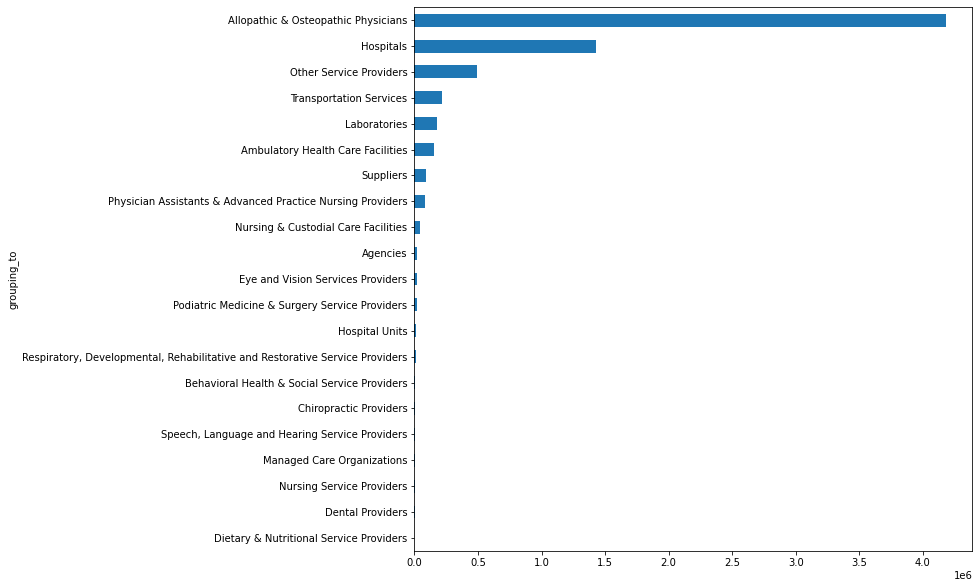

In [97]:
#number of patient per recieveing group 
nash_npp_hop_fromto.groupby('grouping_to')['patient_count'].sum().sort_values(ascending=True).plot.barh(figsize=(10,10))

<AxesSubplot:ylabel='grouping'>

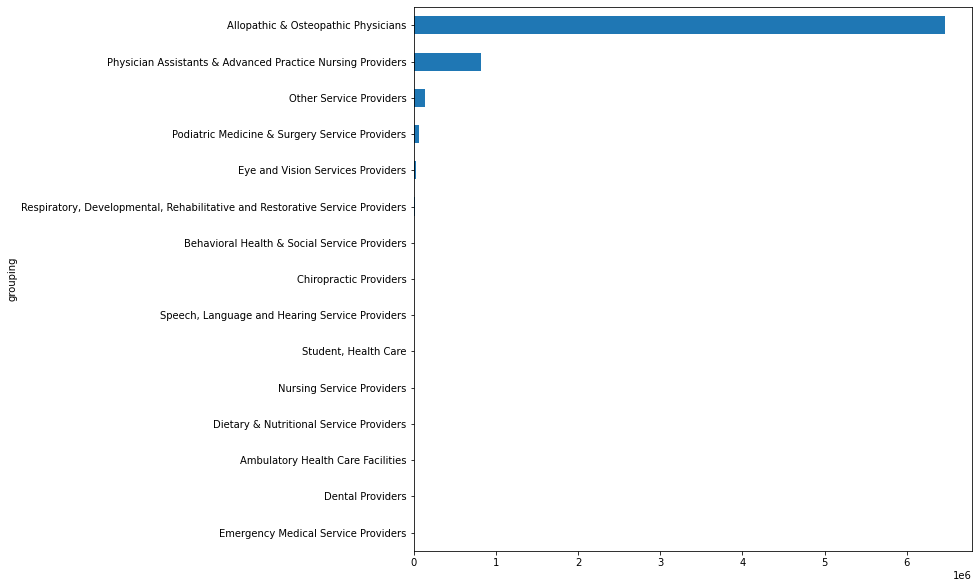

In [98]:
#number of patient per referring group 
nash_npp_hop_fromto.groupby('grouping')['patient_count'].sum().sort_values(ascending=True).plot.barh(figsize=(10,10))

<AxesSubplot:ylabel='classification_to'>

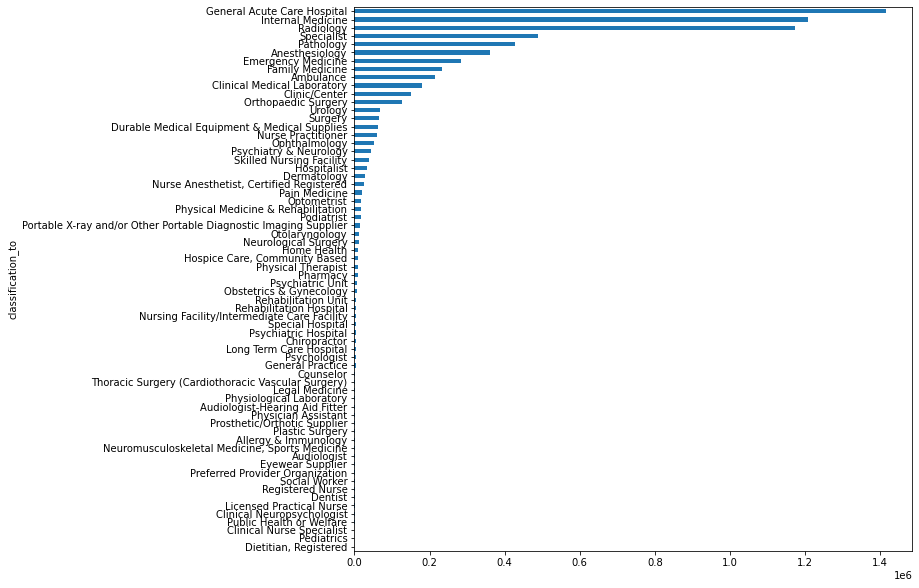

In [99]:
#number of patient per recieving classification/specilization 
nash_npp_hop_fromto.groupby('classification_to')['patient_count'].sum().sort_values(ascending=True).plot.barh(figsize=(10,10))

<AxesSubplot:ylabel='classification'>

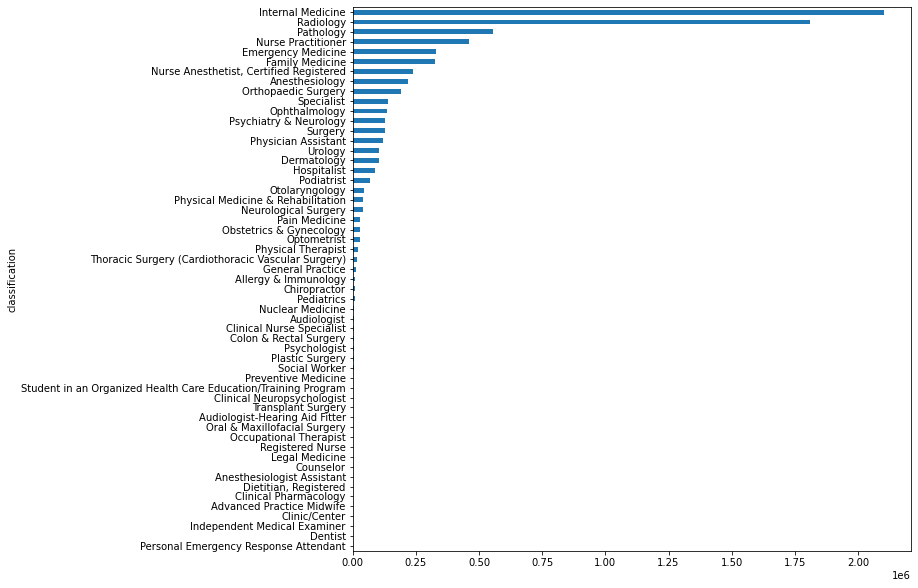

In [100]:
#number of patient per refering classification/specilization 
nash_npp_hop_fromto.groupby('classification')['patient_count'].sum().sort_values(ascending=True).plot.barh(figsize=(10,10))

<AxesSubplot:ylabel='specialization_to'>

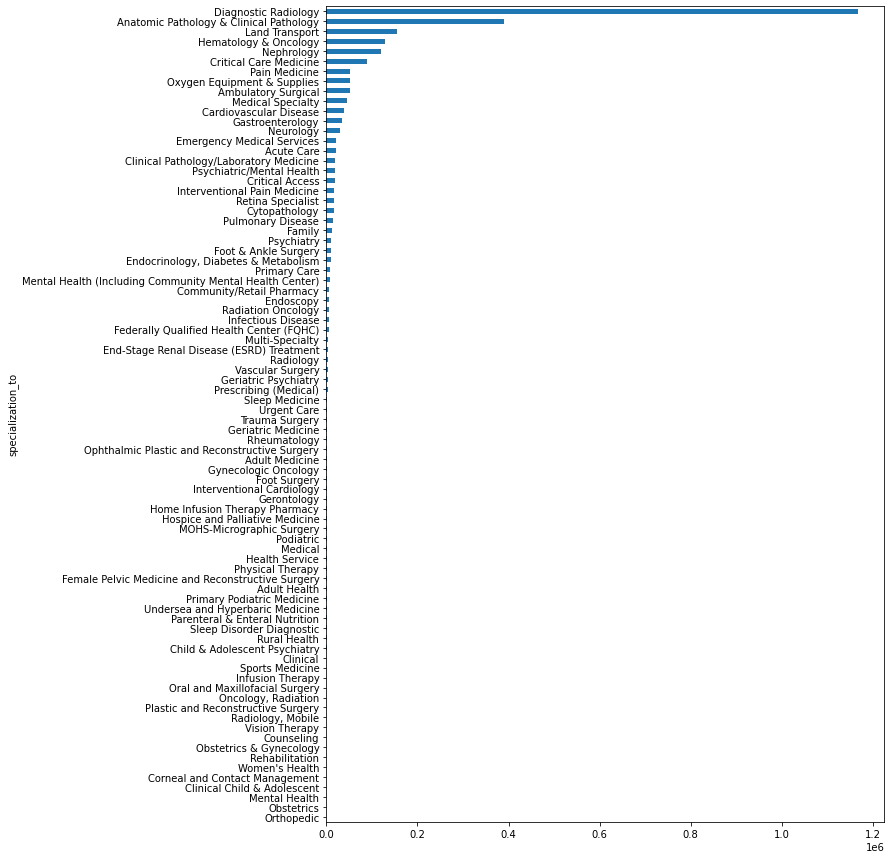

In [101]:
#number of patient per recieving specilization 
nash_npp_hop_fromto.groupby('specialization_to')['patient_count'].sum().sort_values(ascending=True).plot.barh(figsize=(10,15))

<AxesSubplot:ylabel='specialization'>

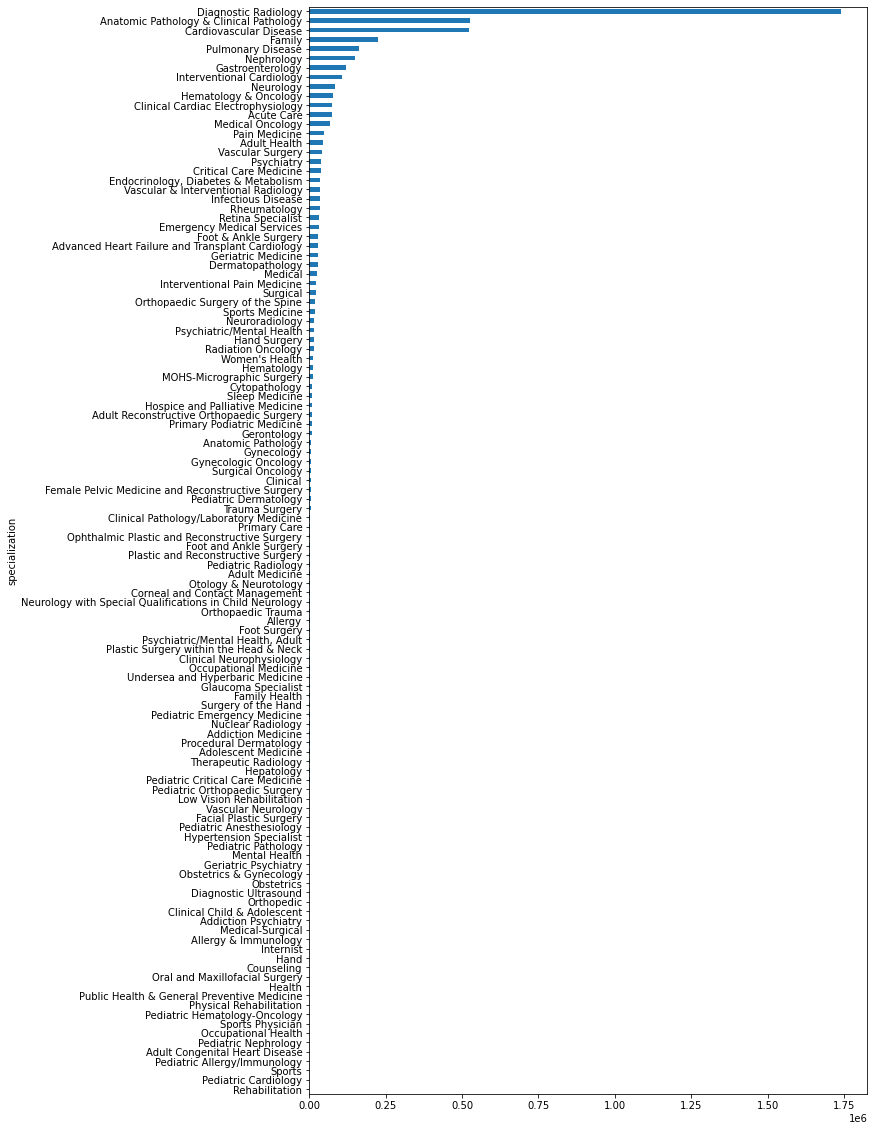

In [103]:
#number of patient per referring specilization 
nash_npp_hop_fromto.groupby('specialization')['patient_count'].sum().sort_values(ascending=True).plot.barh(figsize=(10,20))

<AxesSubplot:ylabel='classification'>

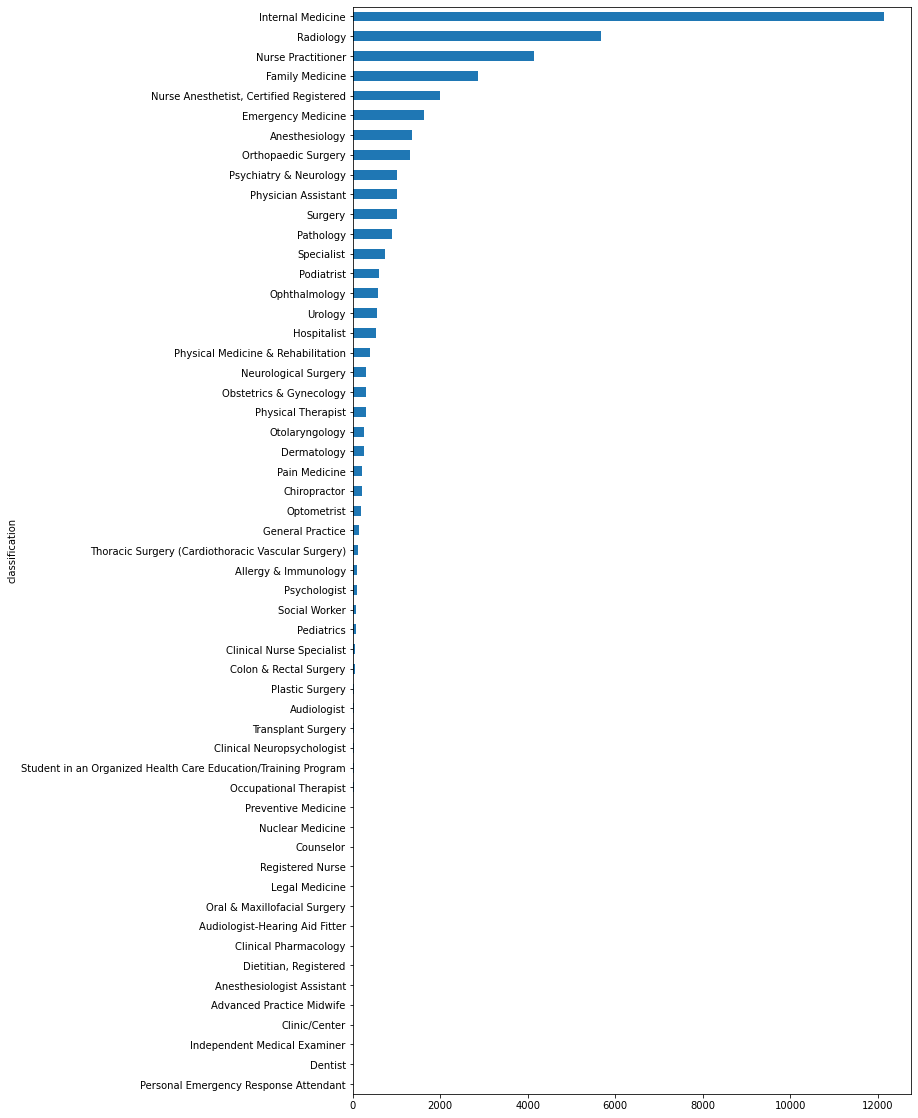

In [104]:
#how many referring providers in each classification 
nash_npp_hop_fromto.groupby('classification')['to_npi'].count().sort_values(ascending=True).plot.barh(figsize=(10,20))

<AxesSubplot:ylabel='specialization'>

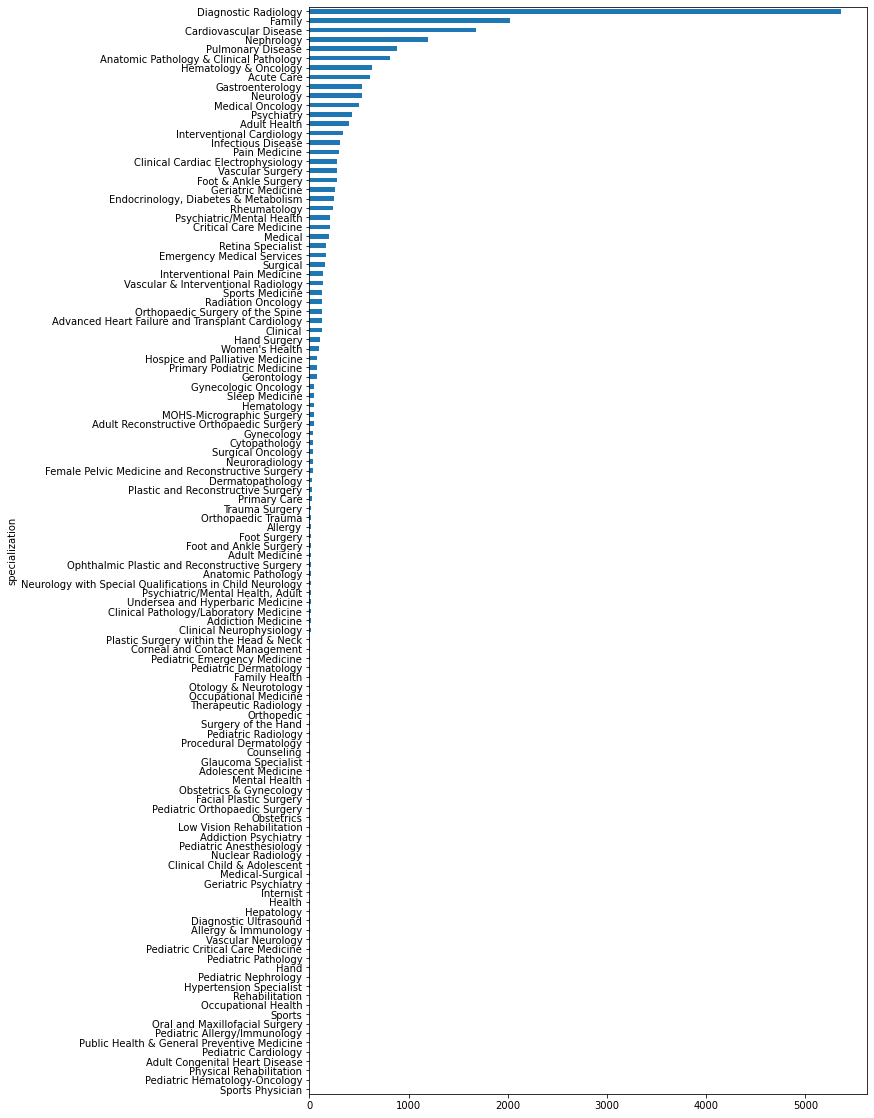

In [24]:
#how many referring providers in each specilization 
nash_npp_hop_fromto.groupby('specialization')['to_npi'].count().sort_values(ascending=True).plot.barh(figsize=(10,20))

<AxesSubplot:ylabel='specialization_to'>

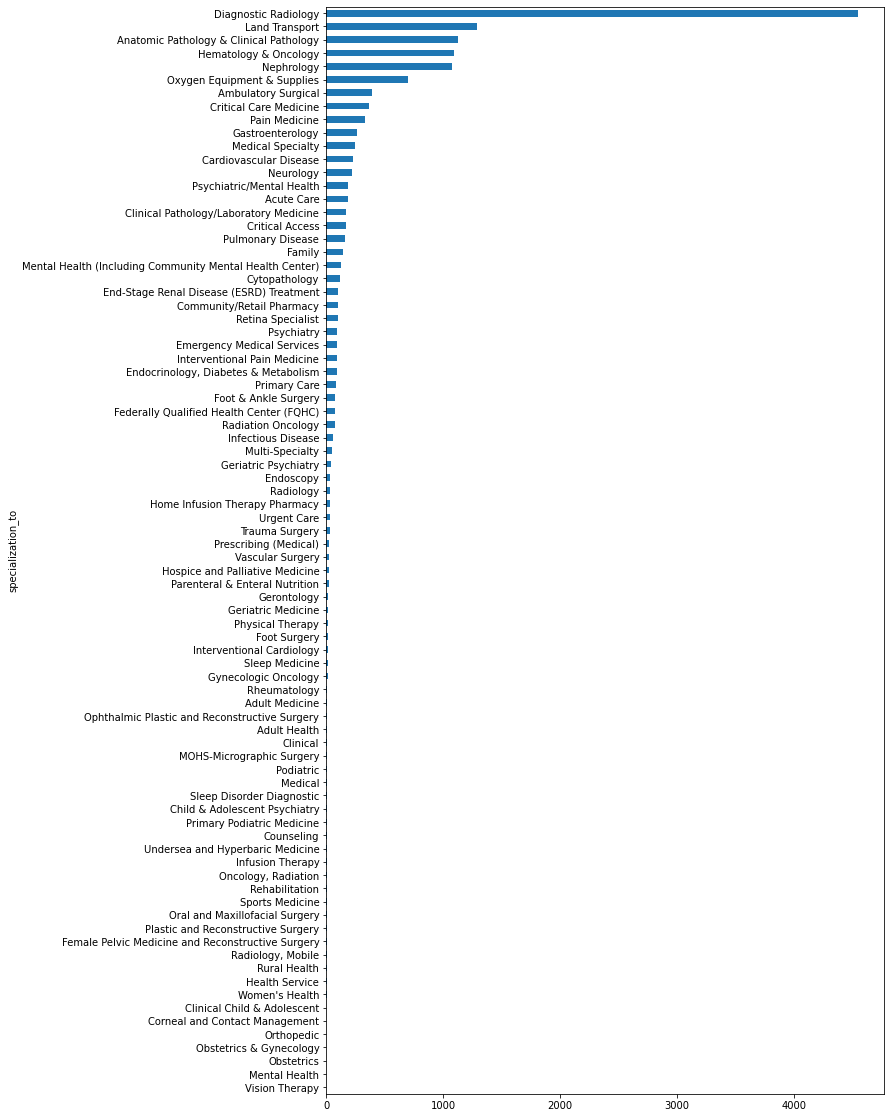

In [23]:

#how many recieving providers in each specilization
nash_npp_hop_fromto.groupby('specialization_to')['from_npi'].count().sort_values(ascending=True).plot.barh(figsize=(10,20))

<AxesSubplot:ylabel='classification_to'>

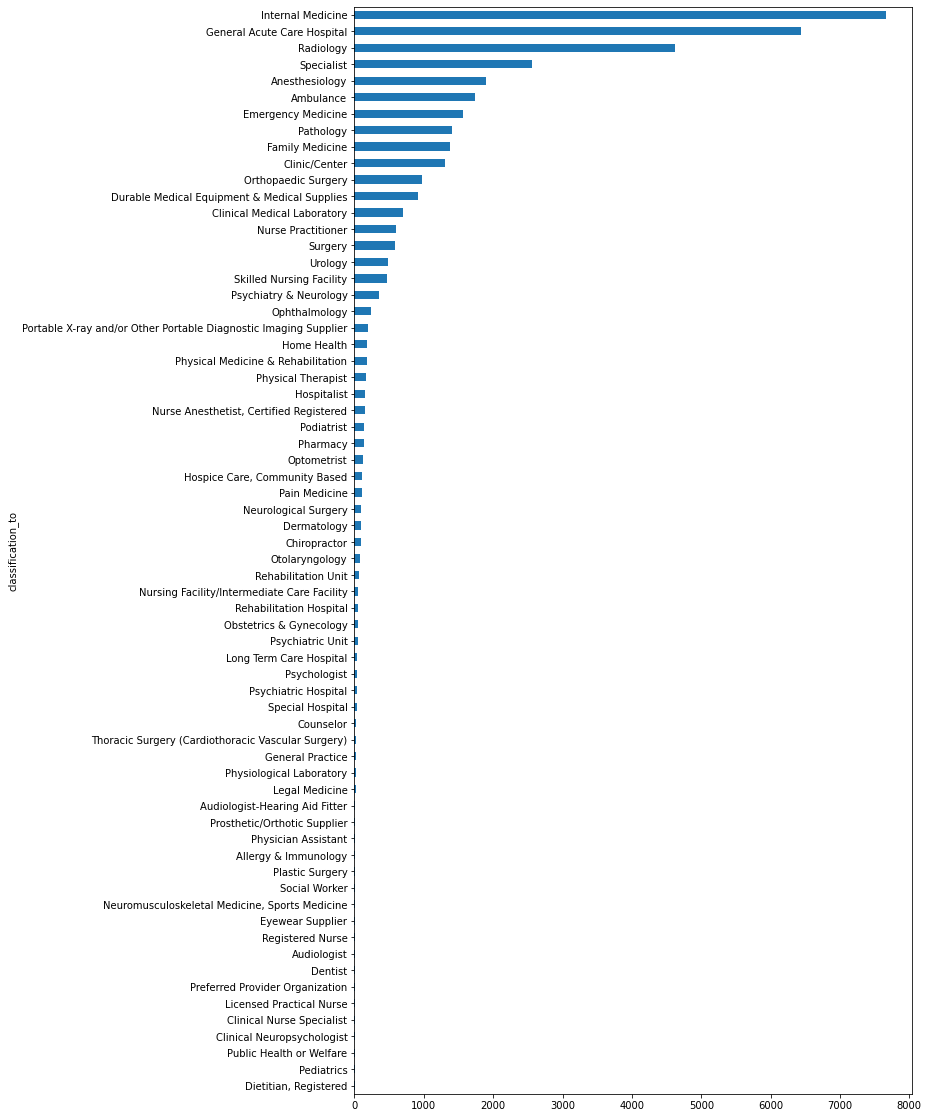

In [15]:

#how many referring providers in each clasification 
nash_npp_hop_fromto.groupby('classification_to')['from_npi'].count().sort_values(ascending=True).plot.barh(figsize=(10,20))

In [106]:
organ_ref_numb=nash_npp_hop_fromto.groupby([
    'provider_organization_name_legal_business_name_to'])[
    'from_npi'].count().reset_index(name="count")

<AxesSubplot:ylabel='provider_organization_name_legal_business_name_to'>

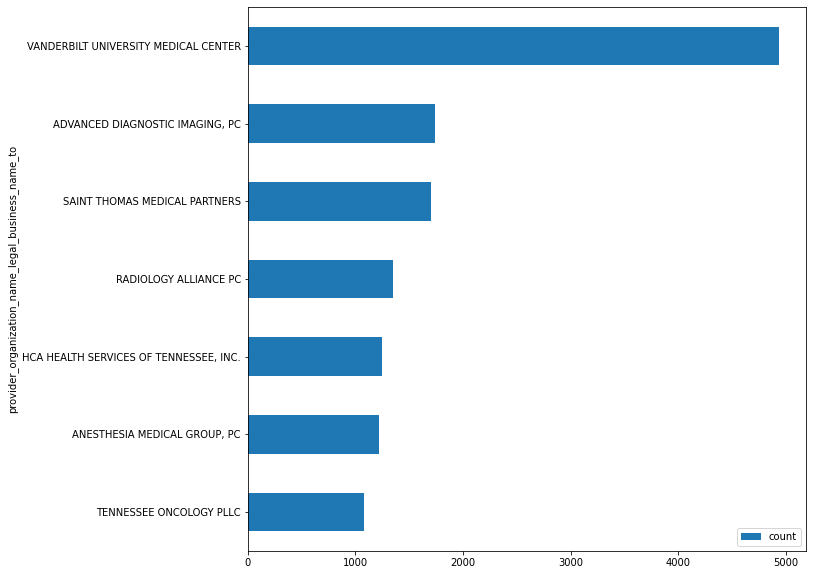

In [107]:
organ_ref_numb=organ_ref_numb[organ_ref_numb['count']>=1000]
organ_ref_numb.sort_values(by='count', 
                           ascending=True).plot.barh(
    x='provider_organization_name_legal_business_name_to', 
    y='count', figsize=(10,10))

In [21]:
patient_count_referee=nash_npp_hop_fromto.groupby(
    ['provider_organization_name_legal_business_name_to', 'classification','provider_last_name_legal_name', 'provider_first_name'])[
    ['patient_count']].agg('sum').reset_index().sort_values(by=['provider_organization_name_legal_business_name_to', 'patient_count'], ascending=False)

patient_count_referee[(patient_count_referee['patient_count']>4000) & 
                      (patient_count_referee[
                          'classification']!='Radiology') &
                      ((~patient_count_referee[
                          'provider_organization_name_legal_business_name_to'].isin([
                          'VANDERBILT UNIVERSITY MEDICAL CENTER',
                          'VANDERBILT HEALTH AND WILLIAMSON MEDICAL CENTER'])))]
                        
                        
                        
                       

,provider_organization_name_legal_business_name_to,classification,provider_last_name_legal_name,provider_first_name,patient_count
34310,UROLOGY ASSOCIATES PC,Pathology,WELCH,DEREK,5292
25189,RADIOLOGY ALLIANCE PC,Pathology,WELCH,DEREK,8410
23251,PATHOLOGY ASSOCIATES OF ST. THOMAS,Dermatology,ROBBINS,JASON,6462
23241,PATHOLOGY ASSOCIATES OF ST. THOMAS,Dermatology,KANTROW,SARA,5022
22959,"PATHGROUP LABS, LLC",Pathology,WELCH,DEREK,87351
22952,"PATHGROUP LABS, LLC",Pathology,KNIGHT,KATHRYN,5767
11446,"HCA HEALTH SERVICES OF TENNESSEE, INC.",Pathology,WELCH,DEREK,12300
11097,"HCA HEALTH SERVICES OF TENNESSEE, INC.",Internal Medicine,RIDDICK,JOHN,5014
7597,COLUMBIA MEDICAL GROUP - THE FRIST CLINIC INC,Pathology,WELCH,DEREK,5815
6408,CENTENNIAL HEART LLC,Pathology,WELCH,DEREK,5306


In [22]:
patient_count_referee[(patient_count_referee['patient_count']>2000) & 
                      (patient_count_referee[
                          'classification'].isin(['Orthopaedic Surgery','Family Medicine','Internal Medicine'])) &
                      ((~patient_count_referee[
                          'provider_organization_name_legal_business_name_to'].isin([
                          'VANDERBILT UNIVERSITY MEDICAL CENTER',
                          'VANDERBILT HEALTH AND WILLIAMSON MEDICAL CENTER'])))].head(60)

,provider_organization_name_legal_business_name_to,classification,provider_last_name_legal_name,provider_first_name,patient_count
26460,SAINT THOMAS MEDICAL PARTNERS,Internal Medicine,GIBSON,DAVID,3059
26469,SAINT THOMAS MEDICAL PARTNERS,Internal Medicine,GRAVES,DANTE,2519
24713,RADIOLOGY ALLIANCE PC,Internal Medicine,RIDDICK,JOHN,3528
11097,"HCA HEALTH SERVICES OF TENNESSEE, INC.",Internal Medicine,RIDDICK,JOHN,5014
11134,"HCA HEALTH SERVICES OF TENNESSEE, INC.",Internal Medicine,WHEATLEY,ROBERT,2515
6138,CENTENNIAL HEART LLC,Internal Medicine,RIDDICK,JOHN,4858
6180,CENTENNIAL HEART LLC,Internal Medicine,WHEATLEY,ROBERT,2721
5964,CENTENNIAL HEART LLC,Internal Medicine,CALLISTER,TRACY,2216
5977,CENTENNIAL HEART LLC,Internal Medicine,CONLEY,CHRISTOPHER,2066
6073,CENTENNIAL HEART LLC,Internal Medicine,LEE,JUNG,2057


In [ ]:
nash_npp_hop_fromto['classification'].unique()

In [213]:
db.close()

In [214]:
#create data for neo4j network analsys (no filter on nnp_from.entity_type_code=1 and nnp_to.entity_type_code=2)

db = sqlite3.connect('nppes.sqlite')
query= '''
select 
nnp_from.entity_type_code,
nnp_from.employer_identification_number_ein,
nnp_from.provider_organization_name_legal_business_name,
nnp_from.provider_last_name_legal_name,
nnp_from.provider_first_name,
nnp_from.provider_business_practice_location_address_city_name,
nnp_from.provider_gender_code,
nnp_from.grouping,
nnp_from.classification,
nnp_from.specialization, 
nnp_to.entity_type_code as entity_type_code_to,
nnp_to.employer_identification_number_ein as employer_identification_number_ein_to,
nnp_to.provider_organization_name_legal_business_name as provider_organization_name_legal_business_name_to,
nnp_to.provider_last_name_legal_name as provider_last_name_legal_name_to,
nnp_to.provider_first_name as provider_first_name_to,
nnp_to.provider_business_practice_location_address_city_name as provider_business_practice_location_address_city_name_to,
nnp_to.provider_gender_code as provider_gender_code_to,
nnp_to.grouping as grouping_to,
nnp_to.classification as classification_to,
nnp_to.specialization as specialization_to,
from_npi,to_npi, patient_count, transaction_count, average_day_wait, std_day_wait

from hop as hp
inner join nash_npp as nnp_from
on hp.from_npi=nnp_from.npi
inner join nash_npp as nnp_to
on nnp_to.npi=hp.to_npi
'''
npp_hop_neo4j = pd.read_sql(query, db)
npp_hop_neo4j



,entity_type_code,employer_identification_number_ein,provider_organization_name_legal_business_name,provider_last_name_legal_name,provider_first_name,provider_business_practice_location_address_city_name,provider_gender_code,grouping,classification,specialization,...,provider_gender_code_to,grouping_to,classification_to,specialization_to,from_npi,to_npi,patient_count,transaction_count,average_day_wait,std_day_wait
0,2.0,<UNAVAIL>,"HCA HEALTH SERVICES OF TENNESSEE, INC.",None,None,NASHVILLE,None,Hospitals,General Acute Care Hospital,None,...,M,Allopathic & Osteopathic Physicians,Orthopaedic Surgery,None,1023055126,1003013947,69,142,5.535,27.885
1,2.0,<UNAVAIL>,"PROTECH MEDICAL,LLC",None,None,COLUMBIA,None,Suppliers,Durable Medical Equipment & Medical Supplies,Oxygen Equipment & Supplies,...,None,Allopathic & Osteopathic Physicians,Dermatology,None,1013154723,1003028770,32,50,41.940,52.320
2,1.0,None,None,HAYES,BENJAMIN,SPRING HILL,M,Allopathic & Osteopathic Physicians,Dermatology,Pediatric Dermatology,...,None,Allopathic & Osteopathic Physicians,Dermatology,None,1003963976,1003028770,2535,3945,0.000,0.000
3,2.0,<UNAVAIL>,"HCA HEALTH SERVICES OF TENNESSEE, INC.",None,None,NASHVILLE,None,Hospitals,General Acute Care Hospital,None,...,M,Allopathic & Osteopathic Physicians,Orthopaedic Surgery,Hand Surgery,1023055126,1003031261,69,99,37.778,69.205
4,2.0,<UNAVAIL>,MID SOUTH PSYCHIATRIC ASSOCIATES,None,None,MURFREESBORO,None,Behavioral Health & Social Service Providers,Psychologist,Prescribing (Medical),...,F,Allopathic & Osteopathic Physicians,Family Medicine,None,1013109511,1003075862,112,360,23.950,19.562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139390,2.0,<UNAVAIL>,SUMMIT PRIMARY CARE,None,None,HERMITAGE,None,Allopathic & Osteopathic Physicians,Family Medicine,None,...,M,Allopathic & Osteopathic Physicians,Radiology,Diagnostic Radiology,1255419255,1255318051,148,151,38.238,46.841
139391,2.0,<UNAVAIL>,CENTENNIAL HEART LLC,None,None,NASHVILLE,None,Other Service Providers,Specialist,None,...,M,Allopathic & Osteopathic Physicians,Orthopaedic Surgery,None,1245393057,1255324281,139,158,49.747,60.133
139392,2.0,<UNAVAIL>,CENTENNIAL HEART LLC,None,None,NASHVILLE,None,Other Service Providers,Specialist,None,...,M,Allopathic & Osteopathic Physicians,Family Medicine,None,1245393057,1255355277,51,88,29.614,39.042
139393,2.0,<UNAVAIL>,CENTENNIAL HEART LLC,None,None,NASHVILLE,None,Other Service Providers,Specialist,None,...,None,Agencies,Home Health,None,1245393057,1255356143,135,167,49.683,52.667


In [33]:
npp_hop_neo4j['from_name']=npp_hop_neo4j[['provider_last_name_legal_name','provider_first_name']].astype(str).agg('-'.join, axis=1)
npp_hop_neo4j['to_name']=npp_hop_neo4j[['provider_last_name_legal_name_to','provider_first_name_to']].astype(str).agg('-'.join, axis=1)

In [35]:
npp_hop_neo4j=npp_hop_neo4j[['classification','classification_to', 'from_npi', 'to_npi', 'from_name', 'to_name', 'patient_count']]

In [37]:
npp_hop_neo4j.to_csv('npp_hop_neo4j.csv')

In [52]:
hop_net=pd.read_csv('netcommunity.csv')

In [18]:
hop_net

,name,communityId
0,1003013947,1406
1,1003019902,1410
2,1003028770,58
3,1003031261,6752
4,1003037029,58
...,...,...
7514,1992972087,1406
7515,1992978845,7
7516,1992985055,7220
7517,1992985949,1406


In [8]:
hop_net_numnode=hop_net.groupby(['communityId'])['name'].count().reset_index(name="Number of node")


<AxesSubplot:ylabel='communityId'>

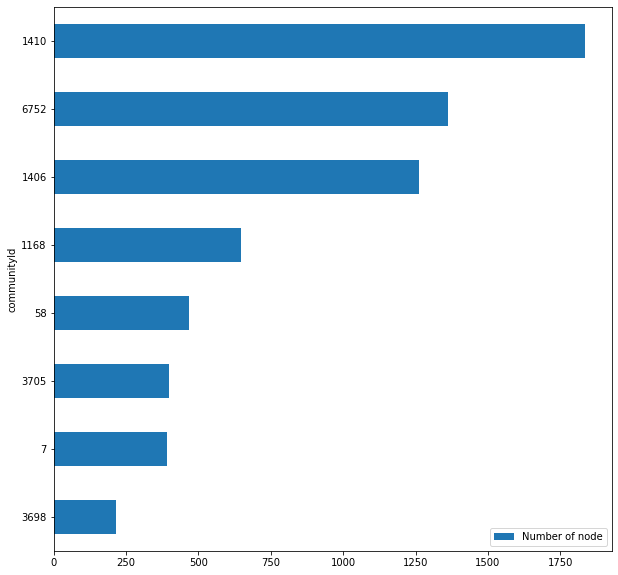

In [9]:
hop_net_numnode100=hop_net_numnode[hop_net_numnode['Number of node']>=100]
hop_net_numnode100.sort_values(by='Number of node', ascending=True).plot.barh(x='communityId', y='Number of node', figsize=(10,10))

In [51]:
npp_nucc_cbsa_nash2=pd.read_csv('npp_taxo_cbsa_nash.csv')

In [53]:
hopnetneo2=pd.merge(hop_net, npp_nucc_cbsa_nash2, left_on='name', right_on='npi', how='left')


In [73]:
hopnetneo2.to_csv('hopnetneo2.csv')

In [49]:
#to see who is refering  patients in this network community
hopnetneo2[hopnetneo2['communityId']==6752]['provider_organization_name_legal_business_name'].unique().tolist()

[None,
 'KROGER LIMITED PARTNERSHIP I',
 'NOL, LLC',
 'JOSEPH B DELOZIER III MD PLLC',
 'PAIN MANAGEMENT GROUP, P.C.',
 'W GARRISON STRICKLAND MD, PC',
 'T SCOTT BAKER MD PC',
 'SOME OTHER COMPANY, INC',
 'URBAN PHYSICAL THERAPY, INC',
 'QUALITY CENTER FOR REHABILITATION AND HEALING',
 'BLAKEFORD AT GREEN HILLS CORPORATION',
 'H DOUGLAS HOLLIDAY MD PLLC',
 'UAP NASHVILLE ENDOSCOPY, LLC',
 'TENNESSEE ORTHOPAEDIC ALLIANCE PA',
 'SAINT THOMAS WEST HOSPITAL',
 'PREMIERE HOME HEALTH, INC.',
 'LEBANON HMA, LLC',
 'WALGREEN CO',
 'THE PAIN MANAGEMENT GROUP, PC',
 'BADRU, INC',
 'CONTINUUMRX, INC.',
 'PUBLIX TENNESSEE LLC',
 'LAKESHORE ESTATES, INC.',
 'ADVANCED DIAGNOSTIC IMAGING, PC',
 'LEBANON HMA PHYSICIAN MANAGEMENT LLC',
 "WOMEN'S HEALTH SPECIALISTS, PLLC",
 'INNER VISION WOMENS ULTRASOUND PLC',
 'SWAN UROGYNECOLOGY, PC',
 'UAP LEBANON ENDO, LLC',
 'HARDIE V. SORRELS III MD P',
 'FULLERTON MEDICAL CLINIC, PLLC',
 nan,
 'NASHVILLE TMS PLLC',
 'AP OF NASHVILLE, LLC',
 'DIALYSIS CLINIC INC.

In [50]:
#to see who are they referred to in this network community
hopnetneo2[hopnetneo1['communityId']==6752]['provider_organization_name_legal_business_name_to'].unique().tolist()

['HCA HEALTH SERVICES OF TENNESSEE, INC.',
 'ADVANCED DIAGNOSTIC IMAGING, PC',
 'ANESTHESIA MEDICAL GROUP, PC',
 'SAINT THOMAS MEDICAL PARTNERS',
 'TENNESSEE ORTHOPAEDIC ALLIANCE PA',
 'COLUMBIA MEDICAL GROUP - THE FRIST CLINIC INC',
 'RADIOLOGY ALLIANCE PC',
 'SUMNER REGIONAL MEDICAL CENTER LLC',
 None,
 'SAINT THOMAS WEST HOSPITAL',
 'ACLA PC',
 'CARDIOVASCULAR ANESTHESIOLOGISTS PC',
 'VANDERBILT UNIVERSITY MEDICAL CENTER',
 'SOLOMON EMERGENCY PHYSICIANS PLLC',
 'WILLIAMSON COUNTY HOSPITAL DISTRICT',
 'HENDERSONVILLE HOSPITAL CORPORATION',
 'LAB PLUS, LLC',
 'HERITAGE MEDICAL ASSOCIATES PC',
 'NEPHROLOGY ASSOCIATES, PC',
 'TENNESSEE ONCOLOGY PLLC',
 'NOL, LLC',
 'LEBANON HMA, LLC',
 'CROSSROADS MEDICAL GROUP, PLLC',
 'MIDDLE TENNESSEE EMERGENCY PHYSICIANS PC',
 'SELECT SPECIALTY HOSPITAL NASHVILLE INC',
 'ENDOCRINOLOGY DIABETES ASSOCIATES',
 'FAMILY MEDICAL PC',
 'THE SURGICAL CLINIC PLLC',
 'MEDICAL NECESSITIES & SERVICES LLC',
 'TENNESSEE PHYSICIANS ALLIANCE PC',
 'ASSOCIATED UROLO

In [ ]:
#to see who are they referred to in this network community
hopnetneo1[hopnetneo1['communityId']==6752]['provider_organization_name_legal_business_name_to'].unique().tolist()

In [77]:

#to see who are they referred to in this network community
hopnetneo2[hopnetneo2['communityId']==6752]['provider_organization_name_legal_business_name'].unique().tolist()

[nan,
 'KROGER LIMITED PARTNERSHIP I',
 'NOL, LLC',
 'JOSEPH B DELOZIER III MD PLLC',
 'PAIN MANAGEMENT GROUP, P.C.',
 'W GARRISON STRICKLAND MD, PC',
 'T SCOTT BAKER MD PC',
 'SOME OTHER COMPANY, INC',
 'URBAN PHYSICAL THERAPY, INC',
 'QUALITY CENTER FOR REHABILITATION AND HEALING',
 'BLAKEFORD AT GREEN HILLS CORPORATION',
 'H DOUGLAS HOLLIDAY MD PLLC',
 'UAP NASHVILLE ENDOSCOPY, LLC',
 'TENNESSEE ORTHOPAEDIC ALLIANCE PA',
 'SAINT THOMAS WEST HOSPITAL',
 'PREMIERE HOME HEALTH, INC.',
 'LEBANON HMA, LLC',
 'WALGREEN CO',
 'THE PAIN MANAGEMENT GROUP, PC',
 'BADRU, INC',
 'CONTINUUMRX, INC.',
 'PUBLIX TENNESSEE LLC',
 'LAKESHORE ESTATES, INC.',
 'ADVANCED DIAGNOSTIC IMAGING, PC',
 'LEBANON HMA PHYSICIAN MANAGEMENT LLC',
 "WOMEN'S HEALTH SPECIALISTS, PLLC",
 'INNER VISION WOMENS ULTRASOUND PLC',
 'SWAN UROGYNECOLOGY, PC',
 'UAP LEBANON ENDO, LLC',
 'HARDIE V. SORRELS III MD P',
 'FULLERTON MEDICAL CLINIC, PLLC',
 'HANGER PROSTHETICS & ORTHOTICS INC',
 'NASHVILLE TMS PLLC',
 'AP OF NASHVIL

In [64]:
hopnetneo2[hopnetneo2['provider_organization_name_legal_business_name'].str.contains('VANDERBILT',na=False)]


,name,communityId,npi,entity_type_code,replacement_npi,employer_identification_number_ein,provider_organization_name_legal_business_name,provider_last_name_legal_name,provider_first_name,provider_middle_name,...,notes,display_name,postal_code,zip,cbsa,res_ratio,bus_ratio,oth_ratio,tot_ratio,zip1
379,1053449660,1410,1053449660,2.0,NaN,<UNAVAIL>,VANDERBILT UNIVERSITY MEDICAL CENTER,NaN,NaN,NaN,...,NaN,End-Stage Renal Disease (ESRD) Treatment Clini...,37214,37214.0,34980.0,1.000000,1.0,1.0,1.000000,37214
737,1104166313,1410,1104166313,2.0,NaN,<UNAVAIL>,"VANDERBILT MAURY RADIATION ONCOLOGY, LLC",NaN,NaN,NaN,...,NaN,Radiation Oncology Clinic/Center,37174,37174.0,34980.0,0.998663,1.0,1.0,0.998755,37174
741,1104202761,1410,1104202761,2.0,NaN,<UNAVAIL>,VANDERBILT UNIVERSITY MEDICAL CENTER,NaN,NaN,NaN,...,NaN,NaN,37232,37232.0,34980.0,0.000000,1.0,1.0,1.000000,37232
1074,1144241985,1410,1144241985,2.0,NaN,<UNAVAIL>,"VANDERBILT IMAGING SERVICES, LLC",NaN,NaN,NaN,...,"Source: American Board of Medical Specialties,...",Diagnostic Radiology Physician,37212,37212.0,34980.0,1.000000,1.0,1.0,1.000000,37212
1676,1215979190,6752,1215979190,2.0,NaN,<UNAVAIL>,VANDERBILT UNIVERSITY MEDICAL CENTER,NaN,NaN,NaN,...,"Source: Code of Federal Regulations #42, Secti...",Rehabilitation Hospital Unit,37087,37087.0,34980.0,1.000000,1.0,1.0,1.000000,37087
1720,1225135551,1410,1225135551,2.0,NaN,<UNAVAIL>,VANDERBILT HEALTH AND WILLIAMSON MEDICAL CENTE...,NaN,NaN,NaN,...,"Source: American Board of Medical Specialties,...",Internal Medicine Physician,37064,37064.0,34980.0,1.000000,1.0,1.0,1.000000,37064
1812,1235293655,1410,1235293655,2.0,NaN,<UNAVAIL>,"VANDERBILT HOME CARE SERVICES, LLC",NaN,NaN,NaN,...,"Source: CFR42 Chapter IV Part 484, http://ww...",Home Health Agency,37232,37232.0,34980.0,0.000000,1.0,1.0,1.000000,37232
2167,1285091330,1410,1285091330,2.0,NaN,<UNAVAIL>,VANDERBILT UNIVERSITY MEDICAL CENTER,NaN,NaN,NaN,...,Source: Developed by National Council for Pres...,Community/Retail Pharmacy,37232,37232.0,34980.0,0.000000,1.0,1.0,1.000000,37232
2384,1306889597,6752,1306889597,2.0,NaN,<UNAVAIL>,VANDERBILT UNIVERSITY MEDICAL CENTER,NaN,NaN,NaN,...,NaN,General Acute Care Hospital,37087,37087.0,34980.0,1.000000,1.0,1.0,1.000000,37087
3081,1396882205,1410,1396882205,2.0,NaN,<UNAVAIL>,VANDERBILT UNIVERSITY MEDICAL CENTER,NaN,NaN,NaN,...,NaN,General Acute Care Hospital,37232,37232.0,34980.0,0.000000,1.0,1.0,1.000000,37232


In [63]:
hopnetneo2[hopnetneo2['communityId']==6752]

,name,communityId,npi,entity_type_code,replacement_npi,employer_identification_number_ein,provider_organization_name_legal_business_name,provider_last_name_legal_name,provider_first_name,provider_middle_name,...,notes,display_name,postal_code,zip,cbsa,res_ratio,bus_ratio,oth_ratio,tot_ratio,zip1
3,1003031261,6752,1003031261,1.0,NaN,NaN,NaN,RUBRIGHT,JAMES,HARDMAN,...,"Source: American Board of Medical Specialties,...",Orthopaedic Hand Surgery Physician,37203,37203.0,34980.0,1.0,1.0,1.0,1.0,37203
17,1003145541,6752,1003145541,2.0,NaN,<UNAVAIL>,KROGER LIMITED PARTNERSHIP I,NaN,NaN,NaN,...,Source: Developed by National Council for Pres...,Community/Retail Pharmacy,37066,37066.0,34980.0,1.0,1.0,1.0,1.0,37066
21,1003168287,6752,1003168287,1.0,NaN,NaN,NaN,SWAFFORD,CHARLES,RYAN,...,Sources: (1) Council on Certification of Nurse...,Certified Registered Nurse Anesthetist,37205,37205.0,34980.0,1.0,1.0,1.0,1.0,37205
26,1003224155,6752,1003224155,1.0,NaN,NaN,NaN,CALLAHAN,JANICE,NaN,...,NaN,Family Nurse Practitioner,37067,37067.0,34980.0,1.0,1.0,1.0,1.0,37067
38,1003819277,6752,1003819277,1.0,NaN,NaN,NaN,CAGE,JOHN,BRIGHT,...,Source: American Osteopathic Board of Internal...,Cardiovascular Disease Physician,37203,37203.0,34980.0,1.0,1.0,1.0,1.0,37203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7483,1992774798,6752,1992774798,1.0,NaN,NaN,NaN,SNEARLY,WILLIAM,NORMAN,...,"Source: American Board of Medical Specialties,...",Diagnostic Radiology Physician,37027,37027.0,34980.0,1.0,1.0,1.0,1.0,37027
7486,1992790174,6752,1992790174,1.0,NaN,NaN,NaN,INTERLANDI,JOHN,W,...,"Source: American Board of Medical Specialties,...","Endocrinology, Diabetes & Metabolism Physician",37076,37076.0,34980.0,1.0,1.0,1.0,1.0,37076
7496,1992860910,6752,1992860910,2.0,NaN,<UNAVAIL>,SAINT THOMAS WEST HOSPITAL,NaN,NaN,NaN,...,"Source: Expanded from Rhea, Ott, and Shafritz,...",Psychiatric Hospital,37205,37205.0,34980.0,1.0,1.0,1.0,1.0,37205
7499,1992877658,6752,1992877658,1.0,NaN,NaN,NaN,MORGAN,NANCY,F.,...,Source: (1) American Speech-Language-Hearing A...,Audiologist,37205,37205.0,34980.0,1.0,1.0,1.0,1.0,37205


In [199]:
hopnetneo2[hopnetneo2['provider_organization_name_legal_business_name'].str.contains('VANDERBILT',na=False)].communityId.value_counts()


1410    13
6752     3
Name: communityId, dtype: int64

In [200]:
hopnetneo2[hopnetneo2['provider_organization_name_legal_business_name'].str.contains('THOMAS',na=False)].communityId.value_counts()

6752    11
1168     3
1404     1
314      1
Name: communityId, dtype: int64

In [70]:

import matplotlib.pyplot as plt

In [78]:
#add nashville npp_taxo_cbsa_nash to nppes database as table
db = sqlite3.connect('nppes.sqlite')
for chunk in tqdm(pd.read_csv('hopnetneo2.csv', chunksize = 1000)):
    chunk.to_sql('nash_npp_neo', db, if_exists ='append', index = False)

/Users/turik1/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:2653: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  sql.to_sql(


In [108]:
db.close()

In [117]:
#merge back the neo4j community, nashville npp to hop_team data

db = sqlite3.connect('nppes.sqlite')
query= '''
select 
nnp_from.name,
nnp_from.communityId,
nnp_from.npi,
nnp_from.entity_type_code,
nnp_from.employer_identification_number_ein,
nnp_from.provider_organization_name_legal_business_name,
nnp_from.provider_last_name_legal_name,
nnp_from.provider_first_name,
nnp_from.provider_business_practice_location_address_city_name,
nnp_from.provider_gender_code,
nnp_from.grouping,
nnp_from.classification,
nnp_from.specialization, 
nnp_to.entity_type_code as entity_type_code_to,
nnp_to.employer_identification_number_ein as employer_identification_number_ein_to,
nnp_to.provider_organization_name_legal_business_name as provider_organization_name_legal_business_name_to,
nnp_to.provider_last_name_legal_name as provider_last_name_legal_name_to,
nnp_to.provider_first_name as provider_first_name_to,
nnp_to.provider_business_practice_location_address_city_name as provider_business_practice_location_address_city_name_to,
nnp_to.provider_gender_code as provider_gender_code_to,
nnp_to.grouping as grouping_to,
nnp_to.classification as classification_to,
nnp_to.specialization as specialization_to,
from_npi,to_npi, patient_count, transaction_count, average_day_wait, std_day_wait

from hop as hp
inner join nash_npp_neo as nnp_from
on hp.from_npi=nnp_from.name
inner join nash_npp_neo as nnp_to
on hp.to_npi=nnp_to.name
where nnp_from.entity_type_code=1 and nnp_to.entity_type_code=2

'''
nash_npp_hop_fromto_neo = pd.read_sql(query, db)
nash_npp_hop_fromto_neo

,name,communityId,npi,entity_type_code,employer_identification_number_ein,provider_organization_name_legal_business_name,provider_last_name_legal_name,provider_first_name,provider_business_practice_location_address_city_name,provider_gender_code,...,provider_gender_code_to,grouping_to,classification_to,specialization_to,from_npi,to_npi,patient_count,transaction_count,average_day_wait,std_day_wait
0,1003963976,58,1003963976,1.0,None,None,HAYES,BENJAMIN,SPRING HILL,M,...,None,Allopathic & Osteopathic Physicians,Dermatology,None,1003963976,1003028770,2535,3945,0.000,0.000
1,1356304984,1410,1356304984,1.0,None,None,MCBEAN,MARY,SPRING HILL,F,...,None,Allopathic & Osteopathic Physicians,Dermatology,None,1356304984,1003028770,40,70,39.200,45.274
2,1417085606,58,1417085606,1.0,None,None,SULLIVAN,RYAN,SPRING HILL,M,...,None,Allopathic & Osteopathic Physicians,Dermatology,None,1417085606,1003028770,276,603,0.000,0.000
3,1417946203,6808,1417946203,1.0,None,None,WALLACE,ROY,NASHVILLE,M,...,None,Allopathic & Osteopathic Physicians,Dermatology,None,1417946203,1003028770,49,66,41.864,44.229
4,1114074093,58,1114074093,1.0,None,None,ROBB,CHRISTOPHER,SPRING HILL,M,...,None,Allopathic & Osteopathic Physicians,Dermatology,None,1114074093,1003028770,940,1716,0.002,0.097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41423,1114961513,1406,1114961513,1.0,None,None,HUMPHREY,STEVEN,NASHVILLE,M,...,None,Allopathic & Osteopathic Physicians,Internal Medicine,None,1114961513,1992972087,63,98,40.510,48.107
41424,1790833267,1406,1790833267,1.0,None,None,AL OMARY,MALEK,NASHVILLE,M,...,None,Allopathic & Osteopathic Physicians,Internal Medicine,None,1790833267,1992972087,187,611,0.029,0.728
41425,1538105242,1406,1538105242,1.0,None,None,KAUFMAN,ALAN,NASHVILLE,M,...,None,Allopathic & Osteopathic Physicians,Internal Medicine,None,1538105242,1992972087,69,82,38.256,55.007
41426,1114974979,7220,1114974979,1.0,None,None,KATKURI,JITHANDER,SMYRNA,M,...,None,Other Service Providers,Specialist,None,1114974979,1992985055,323,897,0.002,0.067


In [143]:
#calculate number of note per community
hop_net_num_node2['Number of node']=nash_npp_hop_fromto_neo.groupby([
    'communityId'])['name'].count().reset_index(drop=True)

In [144]:
hop_net_num_node2.sort_values('Number of node', ascending=False).reset_index(drop=True)

,communityId,Number of node
0,1406,12161
1,6752,8895
2,1410,5946
3,1168,3833
4,3705,2931
...,...,...
204,3581,1
205,3582,1
206,3590,1
207,3686,1


<AxesSubplot:ylabel='communityId'>

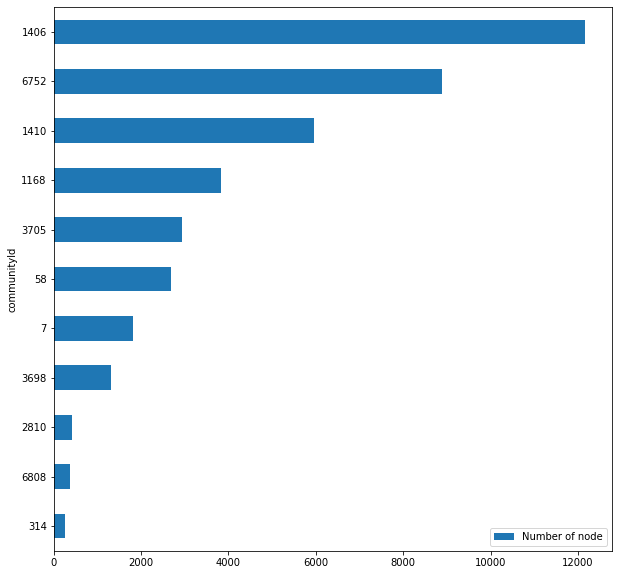

In [587]:
#limiting data to those with greater than hundred providers in the community

hop_net_numnodeg100=hop_net_num_node2[hop_net_num_node2['Number of node']>=200]
hop_net_numnodeg100.sort_values(by='Number of node', ascending=True).plot.barh(x='communityId', y='Number of node', figsize=(10,10))

<ipython-input-588-6dcac3f87cdf>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/turik1/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/turik1/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

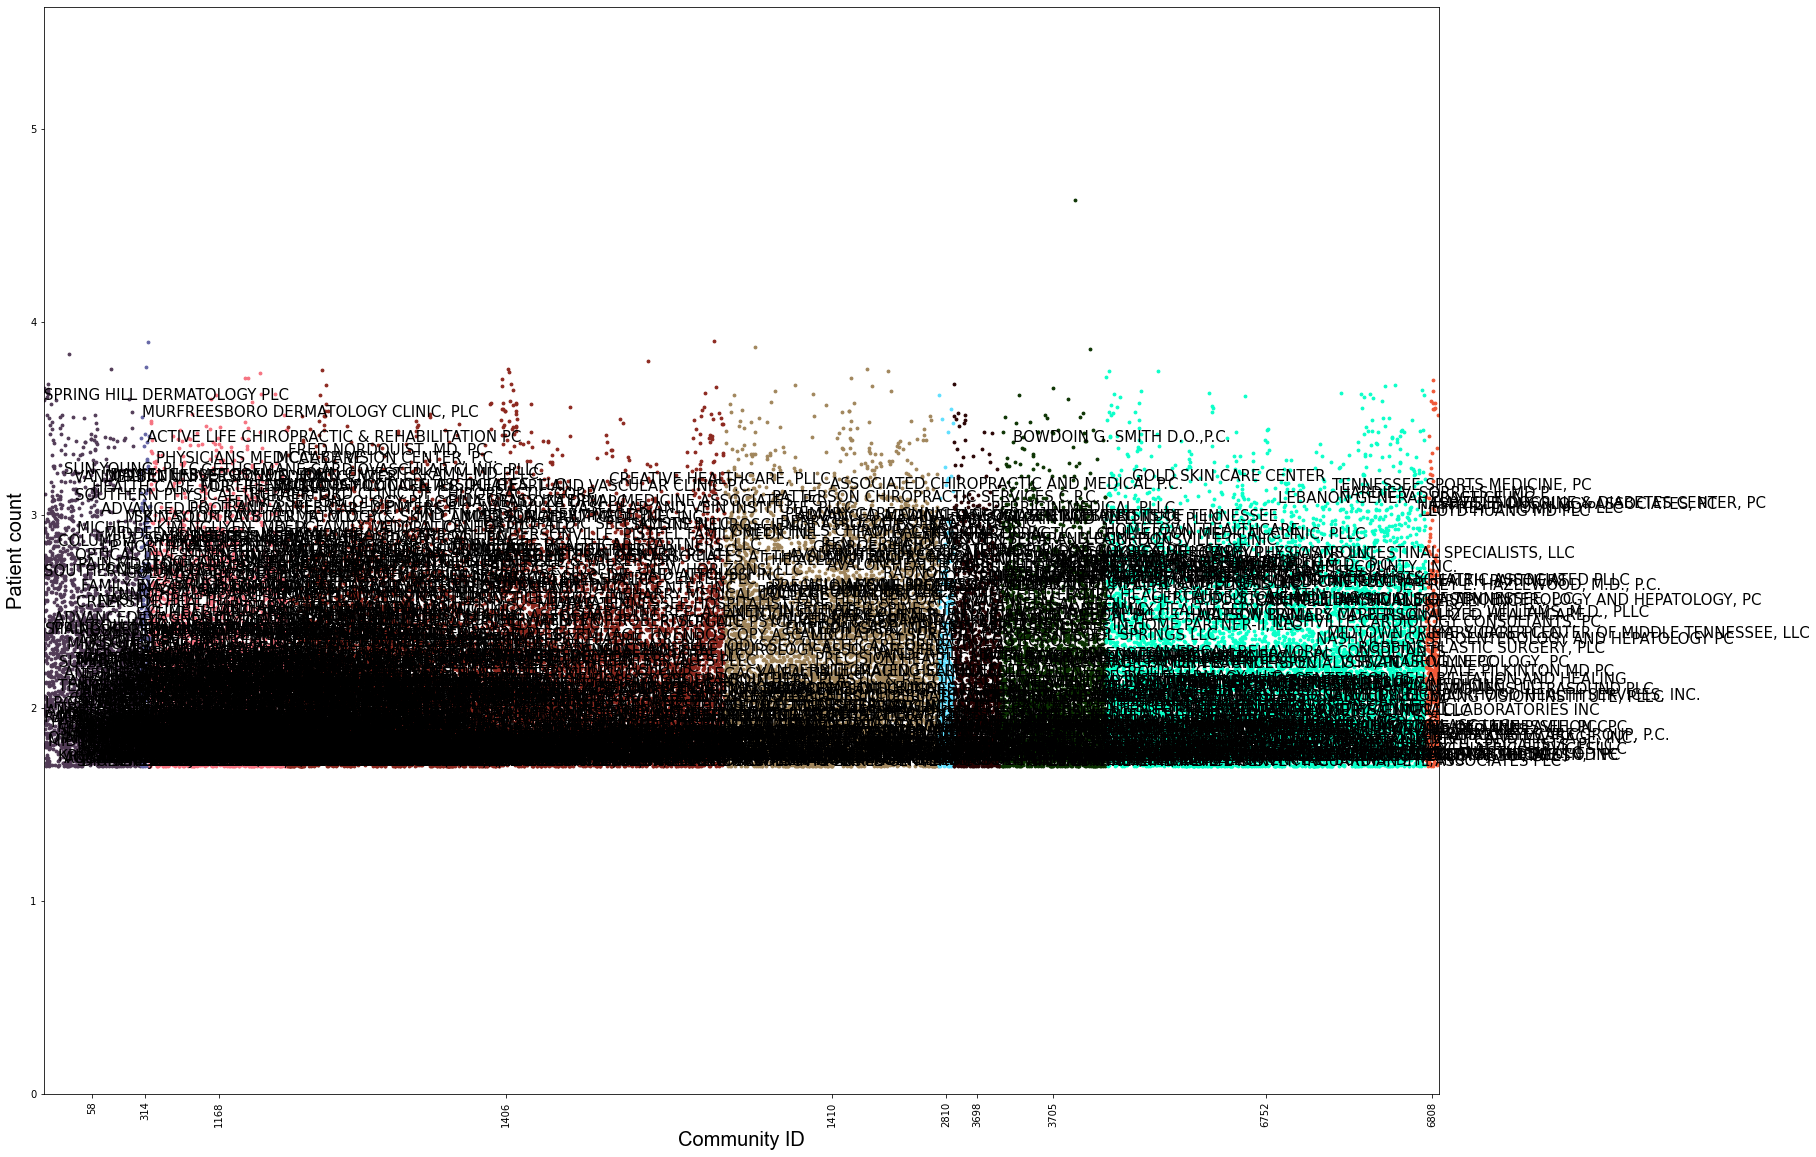

In [588]:
nash_npp_hop_neo_biggs=nash_npp_hop_fromto_neo[nash_npp_hop_fromto_neo[
    'communityId'].isin([1406,6752,1410,1168,3705,58,3698, 2810,6808,314])]
nash_npp_hop_neo_biggs['pvalue']=(1/nash_npp_hop_neo_biggs['transaction_count'])
                                                               
nash_npp_hop_neo_biggs.loc[
    ~nash_npp_hop_neo_biggs.provider_last_name_legal_name.isna(), 'All_names'] = nash_npp_hop_neo_biggs.loc[
    ~nash_npp_hop_neo_biggs.provider_last_name_legal_name.isna(), 'provider_last_name_legal_name'] 

nash_npp_hop_neo_biggs.loc[
    ~nash_npp_hop_neo_biggs.provider_organization_name_legal_business_name_to.isna(), 'All_names'] = nash_npp_hop_neo_biggs.loc[
    ~nash_npp_hop_neo_biggs.provider_organization_name_legal_business_name_to.isna(), 'provider_organization_name_legal_business_name_to']                                                          
                                                             
manhattan=visuz.marker.mhat(df=nash_npp_hop_neo_biggs, chr='communityId', pv='pvalue', 
                  show=True, markernames=True, markeridcol='All_names',
                            gwas_sign_line=False, gwasp=4E-02, dim=(25,20), gfont=15,
                           axxlabel='Community ID', axylabel='Patient count', axlabelfontsize=20)


<ipython-input-589-b028a7230c00>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



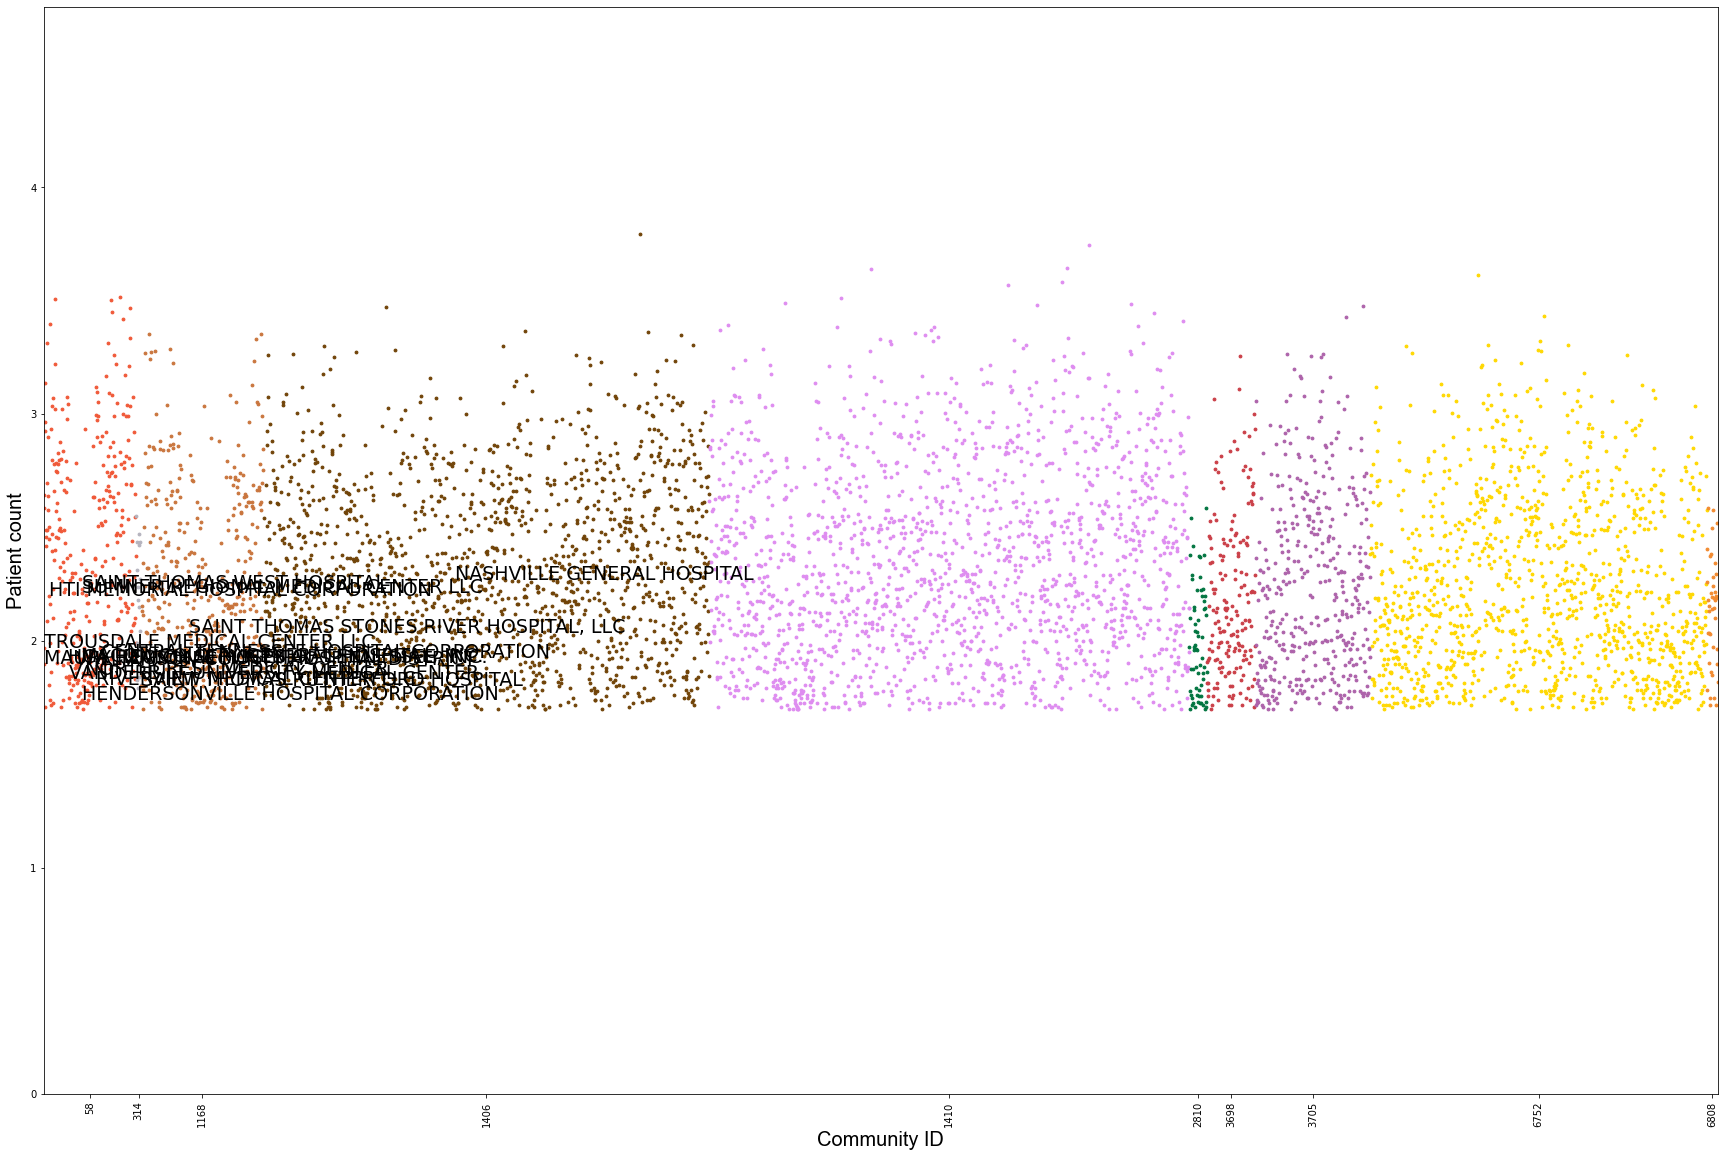

In [589]:
nash_npp_hop_neo_biggs_hos=nash_npp_hop_fromto_neo[(nash_npp_hop_fromto_neo[
    'communityId'].isin([1406,6752,1410,1168,3705,58,3698, 2810,6808,314])) & (nash_npp_hop_fromto_neo[
    'grouping_to'].isin(['Hospitals','Hospital Units'])) & (nash_npp_hop_fromto_neo['classification_to'].isin(['General Acute Care Hospital']))]


nash_npp_hop_neo_biggs_hos['pvalue']=(1/nash_npp_hop_neo_biggs_hos['transaction_count'])

                                                                                                                           
nash_npp_hop_neo_biggs_hos.loc[~nash_npp_hop_neo_biggs_hos.provider_last_name_legal_name_to.isna(), 'All_names'] = nash_npp_hop_neo_biggs_hos.loc[~nash_npp_hop_neo_biggs_hos.provider_last_name_legal_name_to.isna(), 'provider_last_name_legal_name_to'] 

nash_npp_hop_neo_biggs_hos.loc[~nash_npp_hop_neo_biggs_hos.provider_organization_name_legal_business_name_to.isna(), 'All_names'] = nash_npp_hop_neo_biggs_hos.loc[~nash_npp_hop_neo_biggs_hos.provider_organization_name_legal_business_name_to.isna(), 'provider_organization_name_legal_business_name_to']                                                          
                                                             
manhattan=visuz.marker.mhat(df=nash_npp_hop_neo_biggs_hos, chr='communityId', pv='pvalue', 
                  show=True, markernames=True, markeridcol='All_names',
                            gwas_sign_line=False, gwasp=100, dim=(30,20), gfont=19,
                            axxlabel='Community ID', axylabel='Patient count', axlabelfontsize=20)

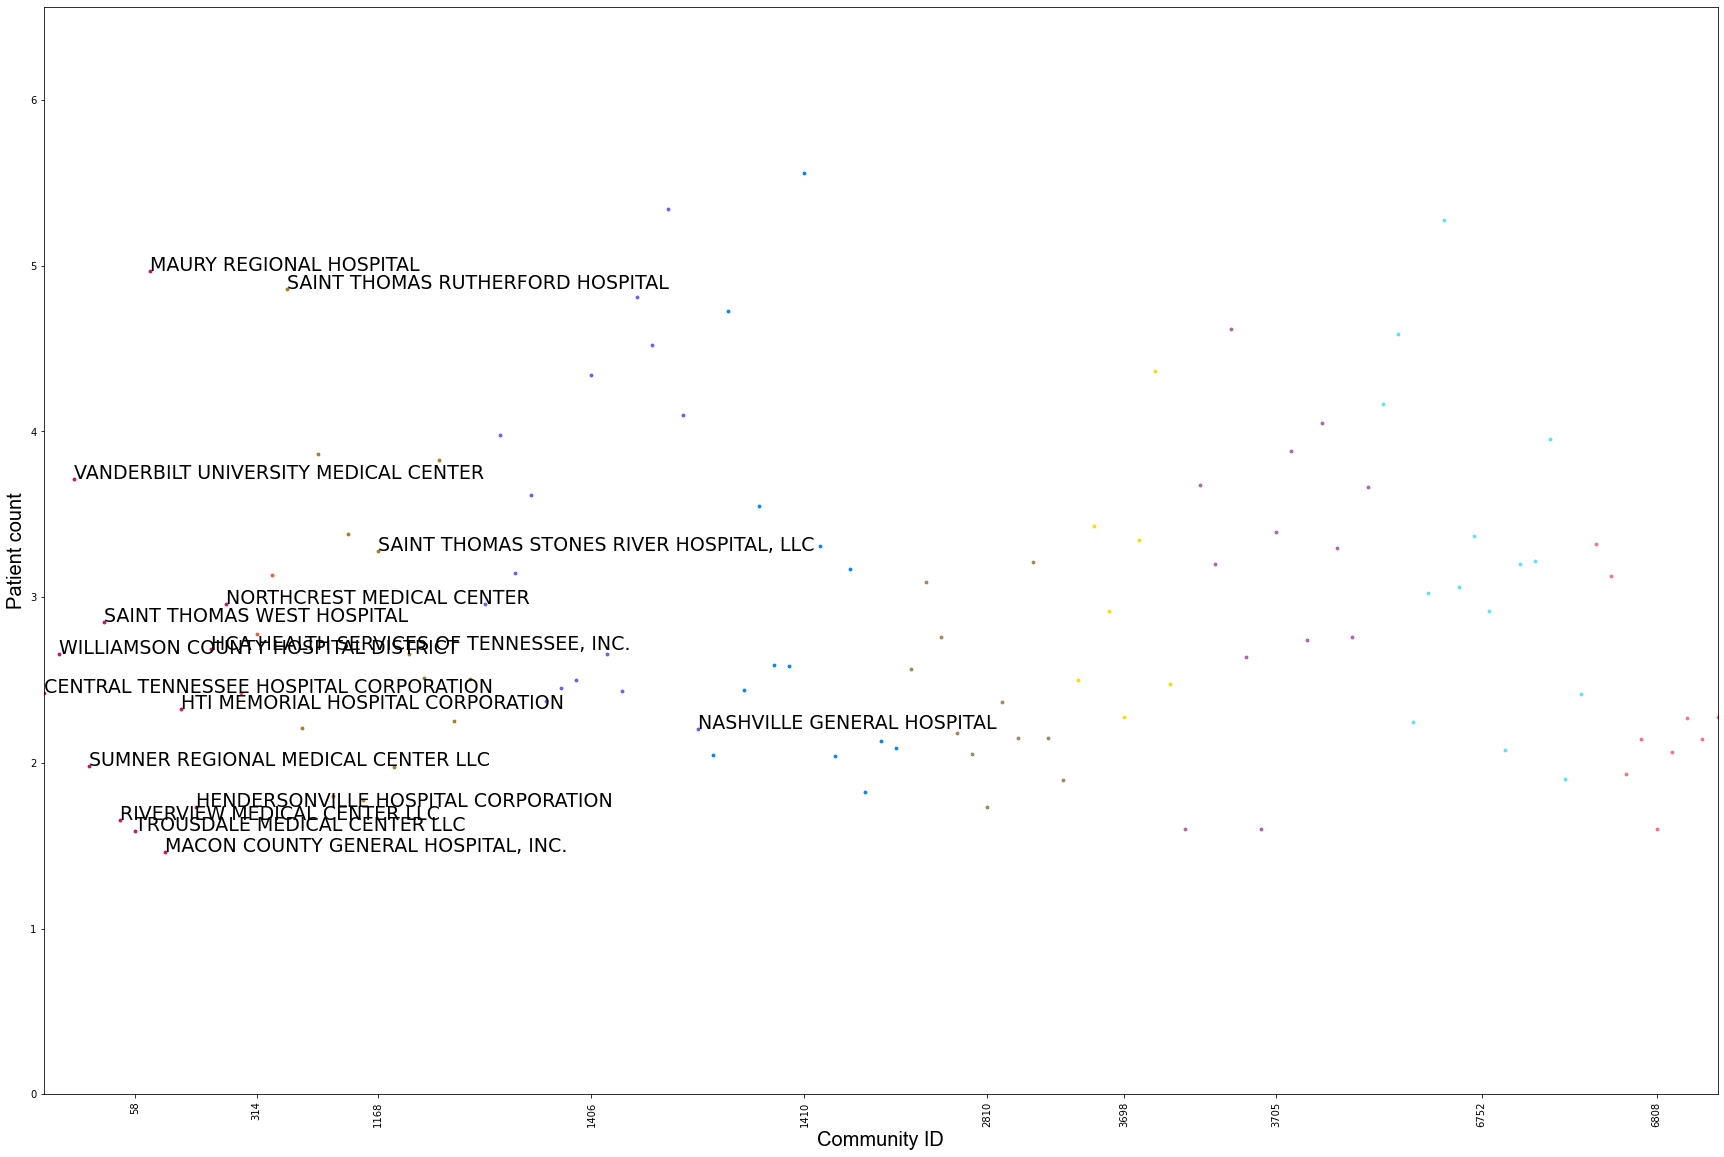

In [590]:
nash_npp_hop_neo_biggs_hos_agg=nash_npp_hop_neo_biggs_hos.groupby(['communityId', 'All_names'])['patient_count'].sum().reset_index(name='Patient_Count')
nash_npp_hop_neo_biggs_hos_agg['pvalue']=(1/nash_npp_hop_neo_biggs_hos_agg['Patient_Count'])

visuz.marker.mhat(df=nash_npp_hop_neo_biggs_hos_agg, chr='communityId', pv='pvalue', 
                  show=True, markernames=True, markeridcol='All_names',
                            gwas_sign_line=False, gwasp=1000, dim=(30,20), gfont=19,
                            axxlabel='Community ID', axylabel='Patient count', axlabelfontsize=20)

In [608]:

nash_npp_hop_neo_biggs_hos_agg_uni=nash_npp_hop_neo_biggs_hos_agg.groupby(
    ['communityId','All_names']).agg(
    {'Patient_Count': 'sum','All_names': 'nunique'}).sort_values(
    ['communityId','Patient_Count'],ascending=False)

nash_npp_hop_neo_biggs_hos_agg_uni=nash_npp_hop_neo_biggs_hos_agg_uni.rename(
    columns={'All_names': 'Names'}).reset_index(col_level='Patient_Count')

nash_npp_hop_neo_biggs_hos_agg_uni=nash_npp_hop_neo_biggs_hos_agg_uni.drop(
    'Names',axis=1).set_index('All_names')


In [616]:
nash_npp_hop_neo_biggs_hos_agg_uni=nash_npp_hop_neo_biggs_hos_agg_uni.reset_index(drop=False)
nash_npp_hop_neo_biggs_hos_agg_uni['Community_ID']=nash_npp_hop_neo_biggs_hos_agg_uni[
    ["communityId"]].astype("str")
nash_npp_hop_neo_biggs_hos_agg_uni

,index,All_names,communityId,Patient_Count,Community_ID
0,0,VANDERBILT UNIVERSITY MEDICAL CENTER,6808,2103,6808
1,1,"HCA HEALTH SERVICES OF TENNESSEE, INC.",6808,1338,6808
2,2,WILLIAMSON COUNTY HOSPITAL DISTRICT,6808,188,6808
3,3,SAINT THOMAS WEST HOSPITAL,6808,186,6808
4,4,MAURY REGIONAL HOSPITAL,6808,140,6808
...,...,...,...,...,...
106,106,SUMNER REGIONAL MEDICAL CENTER LLC,58,96,58
107,107,HENDERSONVILLE HOSPITAL CORPORATION,58,54,58
108,108,RIVERVIEW MEDICAL CENTER LLC,58,45,58
109,109,TROUSDALE MEDICAL CENTER LLC,58,39,58


In [619]:

fig_com = px.bar(nash_npp_hop_neo_biggs_hos_agg_uni, 
             x="All_names", y="Patient_Count", color="Community_ID", 
                 color_discrete_sequence=px.colors.qualitative.D3,
                 labels={"All_names": "Hospitals",
                         "Patient_Count": "Patient Count",
                         "Community_ID": "Network Communities"},
                 title="Hospitals by Number of patient Referrals Recived from Major Network Communities")
fig_com.show()



In [620]:
import chart_studio
import chart_studio.plotly as py
username = 'knturi' # your username
api_key = '9g2VsKlrbQwmJskH87AG' # your api key - go to profile > settings > regenerate key
chart_studio.tools.set_credentials_file(username=username, api_key=api_key)

py.plot(fig_com, filename = "Hospitals_by_Number_of_patient_Referrals_Recived_from_Major_Network_Communities", auto_open=True)

'https://plotly.com/~knturi/3/'

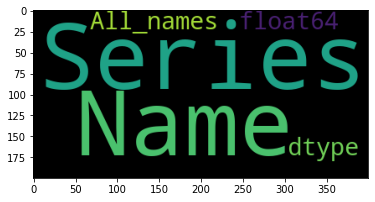

In [364]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

wordcloud = WordCloud().generate(str(n))

plt.imshow(wordcloud)
plt.axis("on")
plt.show()

In [459]:
nash_npp_hop_neo_biggs['classification_to'].tolist()

['Dermatology',
 'Dermatology',
 'Dermatology',
 'Dermatology',
 'Dermatology',
 'Dermatology',
 'Dermatology',
 'Dermatology',
 'Dermatology',
 'Dermatology',
 'Dermatology',
 'Dermatology',
 'Dermatology',
 'Dermatology',
 'Dermatology',
 'Dermatology',
 'Dermatology',
 'Dermatology',
 'Dermatology',
 'Dermatology',
 'Dermatology',
 'Dermatology',
 'Dermatology',
 'Dermatology',
 'Dermatology',
 'Dermatology',
 'Obstetrics & Gynecology',
 'Obstetrics & Gynecology',
 'Obstetrics & Gynecology',
 'Obstetrics & Gynecology',
 'Obstetrics & Gynecology',
 'Obstetrics & Gynecology',
 'Obstetrics & Gynecology',
 'Obstetrics & Gynecology',
 'Obstetrics & Gynecology',
 'Obstetrics & Gynecology',
 'Dermatology',
 'Family Medicine',
 'Family Medicine',
 'Family Medicine',
 'Nurse Practitioner',
 'Nurse Practitioner',
 'Nurse Practitioner',
 'Nurse Practitioner',
 'Nurse Practitioner',
 'Nurse Practitioner',
 'Nurse Practitioner',
 'Nurse Practitioner',
 'Nurse Practitioner',
 'Nurse Practitioner'

In [436]:
from random import sample
from functools import reduce
import sys
from adjustText import adjust_text
def mhat(df="dataframe", chr=None, pv=None, color=None, dim=(6,4), r=300, ar=90, gwas_sign_line=False,
         gwasp=5E-08, dotsize=8, markeridcol=None, markernames=None, gfont=8, valpha=1, show=False, figtype='png',
         axxlabel=None, axylabel=None, axlabelfontsize=9, axlabelfontname="Arial", axtickfontsize=9,
         axtickfontname="Arial", ylm=None, gstyle=1, figname='manhatten'):
    _x, _y = 'Chromosomes', r'$ -log_{10}(P)$'
    rand_colors = ('#a7414a', '#282726', '#6a8a82', '#a37c27', '#563838', '#0584f2', '#f28a30', '#f05837',
                   '#6465a5', '#00743f', '#be9063', '#de8cf0', '#888c46', '#c0334d', '#270101', '#8d2f23',
                   '#ee6c81', '#65734b', '#14325c', '#704307', '#b5b3be', '#f67280', '#ffd082', '#ffd800',
                   '#ad62aa', '#21bf73', '#a0855b', '#5edfff', '#08ffc8', '#ca3e47', '#c9753d', '#6c5ce7',
                   '#a997df', '#513b56', '#590925', '#007fff', '#bf1363', '#f39237', '#0a3200', '#8c271e')
    # minus log10 of P-value
    df['tpval'] = -np.log10(df[pv])
    # df = df.sort_values(chr)
    # if the column contains numeric strings
    df = df.loc[pd.to_numeric(df[chr], errors='coerce').sort_values(ascending=False).index]
    # add indices
    df['ind'] = range(len(df))
    df_group = df.groupby(chr)
    if color is not None and len(color) == 2:
        color_1 = int(df[chr].nunique() / 2) * [color[0]]
        color_2 = int(df[chr].nunique() / 2) * [color[1]]
        if df[chr].nunique() % 2 == 0:
            color_list = list(reduce(lambda x, y: x+y, zip(color_1, color_2)))
        elif df[chr].nunique() % 2 == 1:
            color_list = list(reduce(lambda x, y: x+y, zip(color_1, color_2)))
            color_list.append(color[0])
    elif color is not None and len(color) == df[chr].nunique():
        color_list = color
    elif color is None:
        # select colors randomly from the list based in number of chr
        color_list = sample(rand_colors, df[chr].nunique())
    else:
        print("Error: in color argument")
        sys.exit(1)
    xlabels = []
    xticks = []
    fig, ax = plt.subplots(figsize=dim)
    i = 0
    for label, df1 in df.groupby(chr):
        df1.plot(kind='scatter', x='ind', y='tpval', color=color_list[i], s=dotsize, alpha=valpha, ax=ax)
        df1_max_ind = df1['ind'].iloc[-1]
        df1_min_ind = df1['ind'].iloc[0]
        xlabels.append(label)
        xticks.append((df1_max_ind - (df1_max_ind - df1_min_ind) / 2))
        i += 1
    # add GWAS significant line
    if gwas_sign_line is True:
        ax.axhline(y=-np.log10(gwasp), linestyle='--', color='#7d7d7d', linewidth=1)
    if markernames is not None:
        marker.geneplot_mhat(df, markeridcol, chr, pv, gwasp, markernames, gfont, gstyle, ax=ax)
    ax.margins(x=0)
    ax.margins(y=0)
    ax.set_xticks(xticks)
    ax.set_ylim([0, max(df['tpval'] + 1)])
    if ylm:
        ylm = np.arange(ylm[0], ylm[1], ylm[2])
    else:
        ylm = np.arange(0, max(df['tpval']+1), 1)
    ax.set_yticks(ylm)
    ax.set_xticklabels(xlabels, rotation=ar)
    # ax.set_yticklabels(ylm, fontsize=axtickfontsize, fontname=axtickfontname, rotation=ar)
    if axxlabel:
        _x = axxlabel
    if axylabel:
        _y = axylabel
    ax.set_xlabel(_x, fontsize=axlabelfontsize, fontname=axlabelfontname)
    ax.set_ylabel(_y, fontsize=axlabelfontsize, fontname=axlabelfontname)


<ipython-input-359-7f4295ee04de>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tpval'] = -np.log10(df[pv])


Text(0.5, 1.0, 'title')

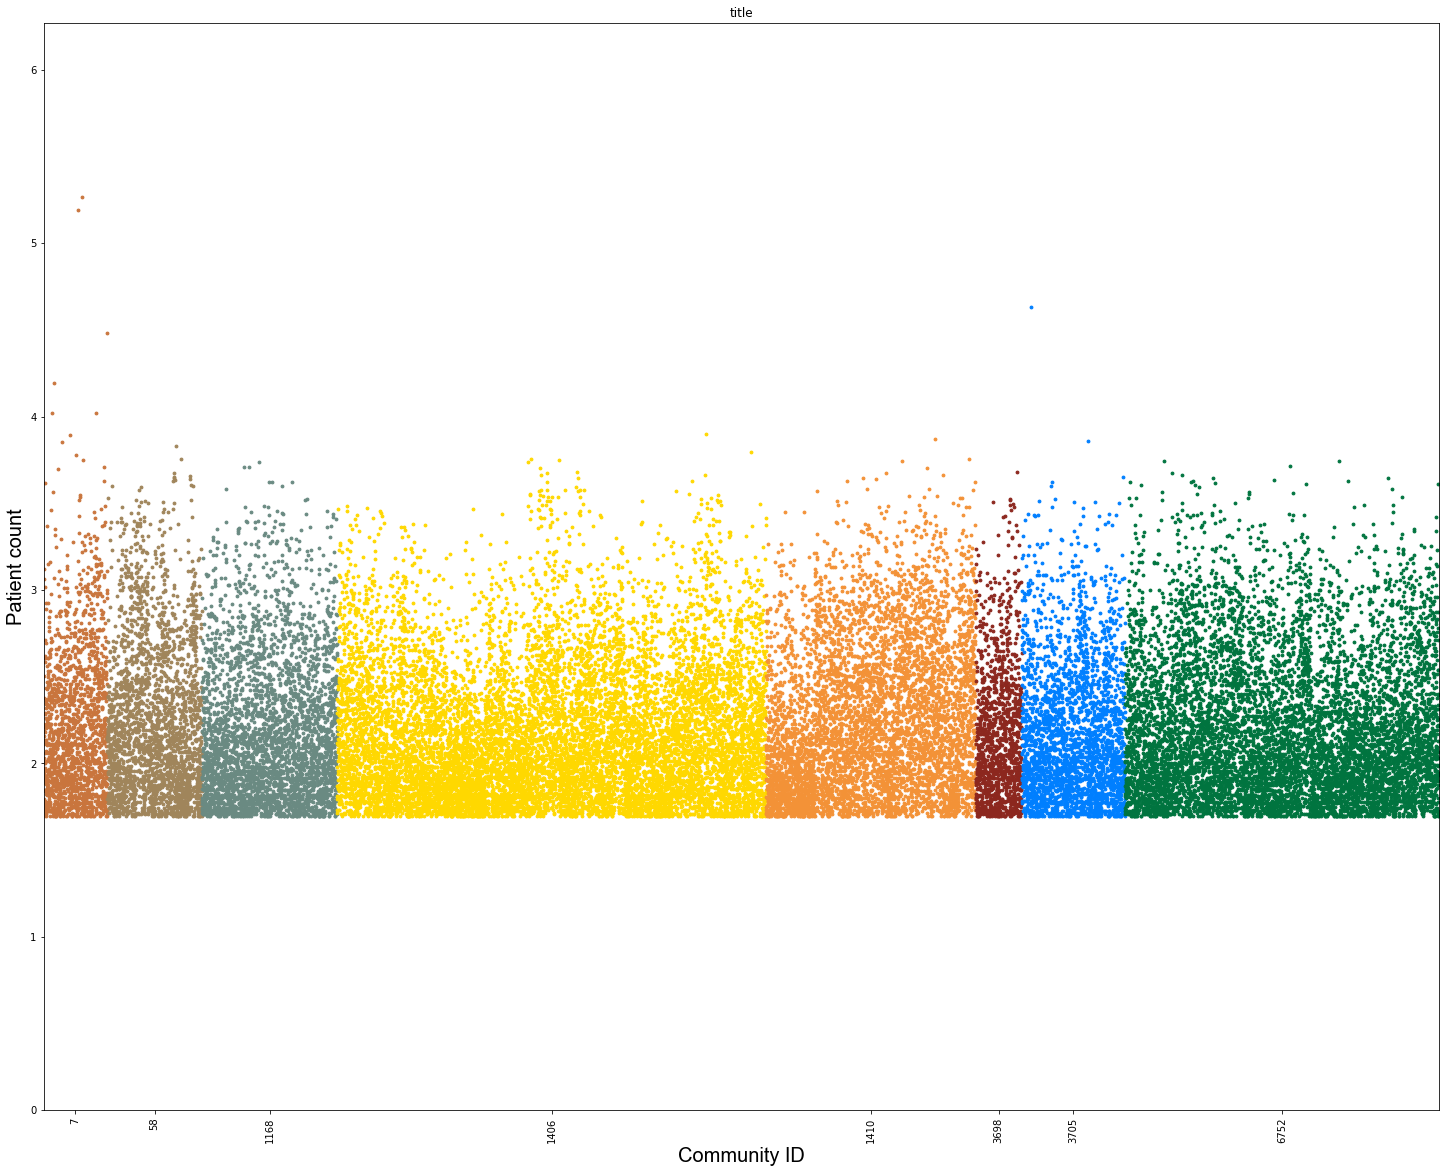

In [360]:
mhat(df=nash_npp_hop_neo_biggs, chr='communityId', pv='pvalue', 
                  show=True, markernames=None, markeridcol='npi',
                            gwas_sign_line=False, gwasp=1E-03, dim=(25,20), gfont=15,
                           axxlabel='Community ID', axylabel='Patient count', axlabelfontsize=20)
plt.title('title')

In [ ]:
from random import sample
from functools import reduce
import sys
from adjustText import adjust_text
def mhat(df="dataframe", chr=None, pv=None, color=None, dim=(6,4), r=300, ar=90, gwas_sign_line=False,
         gwasp=5E-08, dotsize=8, markeridcol=None, markernames=None, gfont=8, valpha=1, show=False, figtype='png',
         axxlabel=None, axylabel=None, axlabelfontsize=9, axlabelfontname="Arial", axtickfontsize=9,
         axtickfontname="Arial", ylm=None, gstyle=1, figname='manhatten'):
    _x, _y = 'Chromosomes', r'$ -log_{10}(P)$'
    rand_colors = ('#a7414a', '#282726', '#6a8a82', '#a37c27', '#563838', '#0584f2', '#f28a30', '#f05837',
                   '#6465a5', '#00743f', '#be9063', '#de8cf0', '#888c46', '#c0334d', '#270101', '#8d2f23',
                   '#ee6c81', '#65734b', '#14325c', '#704307', '#b5b3be', '#f67280', '#ffd082', '#ffd800',
                   '#ad62aa', '#21bf73', '#a0855b', '#5edfff', '#08ffc8', '#ca3e47', '#c9753d', '#6c5ce7',
                   '#a997df', '#513b56', '#590925', '#007fff', '#bf1363', '#f39237', '#0a3200', '#8c271e')
    # minus log10 of P-value
    df['tpval'] = -np.log10(df[pv])
    # df = df.sort_values(chr)
    # if the column contains numeric strings
    df = df.loc[pd.to_numeric(df[chr], errors='coerce').sort_values().index]
    # add indices
    df['ind'] = range(len(df))
    df_group = df.groupby(chr)
    if color is not None and len(color) == 2:
        color_1 = int(df[chr].nunique() / 2) * [color[0]]
        color_2 = int(df[chr].nunique() / 2) * [color[1]]
        if df[chr].nunique() % 2 == 0:
            color_list = list(reduce(lambda x, y: x+y, zip(color_1, color_2)))
        elif df[chr].nunique() % 2 == 1:
            color_list = list(reduce(lambda x, y: x+y, zip(color_1, color_2)))
            color_list.append(color[0])
    elif color is not None and len(color) == df[chr].nunique():
        color_list = color
    elif color is None:
        # select colors randomly from the list based in number of chr
        color_list = sample(rand_colors, df[chr].nunique())
    else:
        print("Error: in color argument")
        sys.exit(1)
    xlabels = []
    xticks = []
    fig, ax = plt.subplots(figsize=dim)
    i = 0
    for label, df1 in df.groupby(chr):
        df1.plot(kind='scatter', x='ind', y='tpval', color=color_list[i], s=dotsize, alpha=valpha, ax=ax)
        df1_max_ind = df1['ind'].iloc[-1]
        df1_min_ind = df1['ind'].iloc[0]
        xlabels.append(label)
        xticks.append((df1_max_ind - (df1_max_ind - df1_min_ind) / 2))
        i += 1
    # add GWAS significant line
    if gwas_sign_line is True:
        ax.axhline(y=-np.log10(gwasp), linestyle='--', color='#7d7d7d', linewidth=1)
    if markernames is not None:
        marker.geneplot_mhat(df, markeridcol, chr, pv, gwasp, markernames, gfont, gstyle, ax=ax)
    ax.margins(x=0)
    ax.margins(y=0)
    ax.set_xticks(xticks)
    ax.set_ylim([0, max(df['tpval'] + 1)])
    if ylm:
        ylm = np.arange(ylm[0], ylm[1], ylm[2])
    else:
        ylm = np.arange(0, max(df['tpval']+1), 1)
    ax.set_yticks(ylm)
    ax.set_xticklabels(xlabels, rotation=ar)
    # ax.set_yticklabels(ylm, fontsize=axtickfontsize, fontname=axtickfontname, rotation=ar)
    if axxlabel:
        _x = axxlabel
    if axylabel:
        _y = axylabel
    ax.set_xlabel(_x, fontsize=axlabelfontsize, fontname=axlabelfontname)
    ax.set_ylabel(_y, fontsize=axlabelfontsize, fontname=axlabelfontname)

